In [1]:
import pandas as pd

# ------------------------------------------------------------
# LOAD
# ------------------------------------------------------------
# df = pd.read_csv("./csv/play_by_play.csv")

def process_chunk(df):
    # ------------------------------------------------------------
    # EVENT CLASSIFICATION
    # ------------------------------------------------------------
    def classify_event(row):
        t = row.eventmsgtype
        if t == 12:
            return "period_start"
        if t == 10:
            return "jump_ball"
        if t == 1:
            return "shot_make"
        if t == 2:
            return "shot_miss"
        if t == 3:
            return "free_throw"
        if t == 4:
            return "rebound"
        if t == 5:
            return "turnover"
        if t == 6:
            return "foul"
        if t == 8:
            return "substitution"
        return "other"

    df["event_class"] = df.apply(classify_event, axis=1)

    # ------------------------------------------------------------
    # POSSESSION PARSER WITH OFFENSIVE REBOUND FIX
    # ------------------------------------------------------------
    df["possession_id"] = -1

    current = 0
    last_team_in_poss = None
    shot_attempt_active = False
    team_that_shot = None

    for i, row in df.iterrows():
        cls = row.event_class
        team = row.player1_team_id

        df.at[i, "possession_id"] = current

        if cls == "jump_ball":
            last_team_in_poss = row.player3_team_id
            shot_attempt_active = False
            team_that_shot = None
            continue

        if cls == "shot_make":
            shot_attempt_active = False
            team_that_shot = row.player1_team_id
            current += 1
            last_team_in_poss = None
            continue

        if cls == "shot_miss":
            shot_attempt_active = True
            team_that_shot = row.player1_team_id
            continue

        if cls == "rebound":
            rebound_team = row.player1_team_id
            if pd.isna(rebound_team):
                rebound_team = None

            if shot_attempt_active:
                if rebound_team == team_that_shot:
                    shot_attempt_active = False
                    team_that_shot = rebound_team
                    continue
                else:
                    shot_attempt_active = False
                    team_that_shot = rebound_team
                    current += 1
                    continue

            last_team_in_poss = rebound_team
            continue

        if cls == "turnover":
            shot_attempt_active = False
            current += 1
            continue

        if cls == "free_throw":
            if "Free Throw" in str(row.homedescription) or "Free Throw" in str(row.visitordescription):
                pass
            continue

    # ------------------------------------------------------------
    # SHOT CHART EXTRACTION
    # ------------------------------------------------------------
    def extract_shot_distance(desc):
        if not isinstance(desc, str):
            return None
        if "'" in desc:
            try:
                d = desc.split("'")[0]
                d = "".join(ch for ch in d if ch.isdigit())
                if d.isdigit():
                    return int(d)
            except:
                return None
        return None

    df["shot_distance"] = df.apply(
        lambda r: extract_shot_distance(r.homedescription) 
                if r.event_class in ["shot_make", "shot_miss"] and isinstance(r.homedescription,str)
                else extract_shot_distance(r.visitordescription), axis=1
    )

    df["shooter"] = df.apply(
        lambda r: r.player1_name if r.event_class in ["shot_make", "shot_miss"] else None,
        axis=1,
    )

    shot_chart = df[df.event_class.isin(["shot_make","shot_miss"])][
        ["shooter","event_class","shot_distance","homedescription","visitordescription","possession_id"]
    ]

    shot_chart = shot_chart.dropna(subset=["shooter"])

    print(shot_chart.head())
    return df, shot_chart


In [3]:
def main():

    first = True
    total = 0

    for chunk in pd.read_csv("./csv/play_by_play.csv", chunksize=500000, low_memory=False):

        cleaned, shots = process_chunk(chunk)
        total += len(cleaned)

        cleaned.to_csv("cleaned_play_by_play.csv", mode="a", index=False, header=first)
        shots.to_csv("clean_shot_data.csv", mode="a", index=False, header=first)
        first = False

        print("Processed rows:", total)

    print("Done cleaning.")

In [4]:
main()

             shooter event_class  shot_distance  \
2        Sam Cassell   shot_miss           15.0   
4    Cedric Ceballos   shot_miss           26.0   
8    Cedric Ceballos   shot_miss            1.0   
12  Shaquille O'Neal   shot_make            NaN   
13        Joe Kleine   shot_miss           11.0   

                               homedescription          visitordescription  \
2                                          NaN  MISS Cassell 15' Jump Shot   
4              MISS Ceballos 26' 3PT Jump Shot                         NaN   
8                       MISS Ceballos 1' Layup         Horry BLOCK (1 BLK)   
12  O'Neal  Slam Dunk (2 PTS) (Van Exel 1 AST)                         NaN   
13                                         NaN   MISS Kleine 11' Jump Shot   

    possession_id  
2               0  
4               1  
8               3  
12              6  
13              7  
Processed rows: 500000
                shooter event_class  shot_distance  \
500007       Mario Elie   s

In [1]:
import pandas as pd

In [2]:
shot_chart = pd.read_parquet("./parquet/clean_shot_data.parquet")

In [5]:
shot_chart.to_parquet("./parquet/clean_shot_data.parquet")

In [3]:
# ------------------------------------------------------------
# AGGREGATE SHOOTING METRICS BY PLAYER
# ------------------------------------------------------------

player_summary = (
    shot_chart
    .groupby("shooter")
    .agg(
        attempts=("event_class", "count"),
        makes=("event_class", lambda x: (x == "shot_make").sum()),
        misses=("event_class", lambda x: (x == "shot_miss").sum()),
        avg_distance=("shot_distance", "mean"),
    )
)

player_summary["FG%"] = player_summary["makes"] / player_summary["attempts"]

player_summary = player_summary.sort_values("attempts", ascending=False)

player_summary.head(20)


attempts  makes  misses  avg_distance       FG%
shooter                                                           
LeBron James          29121  14622   14499     13.645495  0.502112
Kobe Bryant           25263  11293   13970     16.919318  0.447017
Dirk Nowitzki         22623  10618   12005     16.969064  0.469345
Carmelo Anthony       21366   9495   11871     16.214345  0.444398
Tim Duncan            20447  10318   10129      9.169973  0.504622
Russell Westbrook     19460   8465   10995     12.661423  0.434995
Kevin Durant          19419   9587    9832     15.800704  0.493692
Kevin Garnett         19225   9543    9682     13.666258  0.496385
Vince Carter          19094   8300   10794     17.507622  0.434692
Allen Iverson         19021   8069   10952     16.610437  0.424215
Ray Allen             18334   8231   10103     18.218159  0.448947
Paul Pierce           17768   7913    9855     15.944262  0.445351
Dwyane Wade           17607   8413    9194     13.187147  0.477821
James Harden          16874   7399    9475     16.243768  0.438485
Joe Johnson           16529   7273    9256     16.029589  0.440015
Tony Parker           16421   7941    8480     11.757877  0.483588
Stephen Curry         16318   7719    8599     18.714596  0.473036
Chris Paul            16303   7712    8591     16.285168  0.473042
LaMarcus Aldridge     15726   7715    8011     12.199844  0.490589
DeMar DeRozan         15513   7256    8257     12.572675  0.467737

In [7]:
player_summary.to_parquet("./parquet/player_summary.parquet")

In [4]:
player_summary = pd.read_parquet("./parquet/player_summary.parquet")

In [5]:
# ------------------------------------------------------------
# BUILD PER-PLAYER SHOT CHART DICTIONARY
# ------------------------------------------------------------

# Data structure:
# shot_charts["Kobe Bryant"] = DataFrame of all Kobe shots
# shot_charts["Tim Duncan"] = ...
# ...

shot_charts = {
    player: shots.reset_index(drop=True)
    for player, shots in shot_chart.groupby("shooter")
}

# Inspect one player with many attempts
sample_player = list(shot_charts.keys())[0]
shot_charts[sample_player].head(10)


shooter event_class  shot_distance  \
0  A.C. Green   shot_miss           18.0   
1  A.C. Green   shot_miss           11.0   
2  A.C. Green   shot_miss            NaN   
3  A.C. Green   shot_miss           15.0   
4  A.C. Green   shot_make           15.0   
5  A.C. Green   shot_miss           13.0   
6  A.C. Green   shot_make            NaN   
7  A.C. Green   shot_miss           15.0   
8  A.C. Green   shot_make            NaN   
9  A.C. Green   shot_miss            NaN   

                              homedescription        visitordescription  \
0                                        None  MISS Green 18' Jump Shot   
1                                        None  MISS Green 11' Jump Shot   
2                      Campbell BLOCK (1 BLK)         MISS Green  Layup   
3                                        None  MISS Green 15' Jump Shot   
4  Green 15' Jump Shot (2 PTS) (Person 1 AST)                      None   
5                    MISS Green 13' Jump Shot                      None   
6                     Green  Tip Shot (4 PTS)                      None   
7                    MISS Green 15' Jump Shot                      None   
8        Green  Layup (6 PTS) (Cassell 3 AST)                      None   
9                   MISS Green  3PT Jump Shot                      None   

   possession_id  
0             21  
1             23  
2             25  
3            144  
4           3339  
5           3343  
6           3401  
7           3406  
8           3409  
9           3495

In [8]:
# ------------------------------------------------------------
# SHOT DISTANCE DISTRIBUTIONS FOR ALL PLAYERS
# ONE PLOT PER PLAYER (AUTO-GENERATED)
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import os

# output directory
os.makedirs("player_shot_distance_charts", exist_ok=True)

for player, df_player in shot_charts.items():
    dist = df_player["shot_distance"].dropna()
    if len(dist) == 0:
        continue

    plt.figure(figsize=(8,4))
    plt.hist(dist, bins=30)
    plt.xlabel("Shot Distance (feet)")
    plt.ylabel("Frequency")
    plt.title(f"{player} – Shot Distance Distribution")

    safe_name = player.replace(" ", "_")
    plt.savefig(f"player_shot_distance_charts/{safe_name}.png", dpi=150, bbox_inches="tight")
    plt.close()

print("Finished generating charts for all players.")


Finished generating charts for all players.


In [9]:
df = pd.read_csv("./cleaned_play_by_play.csv")

In [10]:
df.to_parquet("./parquet/play_by_play.parquet")

In [6]:
df = pd.read_parquet("./parquet/play_by_play.parquet")

In [8]:
# ============================================================
# POSSESSION EFFICIENCY, SHOT QUALITY MODELING,
# PLAYER INTERACTION NETWORKS
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ------------------------------------------------------------
# 1. POSSESSION EFFICIENCY
# ------------------------------------------------------------
# A possession ends on: made shot, turnover, non-offensive rebound,
# and possession_id already constructed earlier.

# Compute points per possession
df["points"] = df["event_class"].eq("shot_make").astype(int) * df["score"].apply(
    lambda x: int(x.split("-")[1]) if isinstance(x,str) and "-" in x else 0
)

# Summaries
poss_eff = df.groupby("possession_id")["points"].sum()

team_possession_eff = (
    df.groupby(["possession_id","player1_team_id"])["points"]
    .sum()
    .reset_index()
    .groupby("player1_team_id")["points"]
    .mean()
    .sort_values(ascending=False)
)

print("Top teams by possession efficiency:")
print(team_possession_eff.head(10))


# ------------------------------------------------------------
# 2. SHOT QUALITY MODELING
# ------------------------------------------------------------
# Simple model: expected points = P(make) * points_if_make
# using shot distance as a proxy for difficulty.

shot_df = shot_chart.copy()
shot_df["is_make"] = shot_df["event_class"].eq("shot_make").astype(int)

# distance bins
shot_df["dist_bin"] = pd.cut(
    shot_df["shot_distance"],
    bins=[0,3,8,16,23,40],
    labels=["at_rim","short_mid","midrange","long2","three_plus"]
)

# probability of make per distance bucket
shot_quality = (
    shot_df.groupby("dist_bin")["is_make"]
    .mean()
    .rename("prob_make")
    .reset_index()
)

# expected points = prob_make * 2 (except if 3pt)
def bucket_points(b):
    if b=="three_plus":
        return 3
    return 2

shot_quality["expected_points"] = shot_quality["dist_bin"].apply(bucket_points) * shot_quality["prob_make"]

print("Shot quality model:")
print(shot_quality)


# ------------------------------------------------------------
# 3. PLAYER INTERACTION NETWORKS
# ------------------------------------------------------------
# network edges:
#   assist → scorer
#   pass leading to shot
#   steal → victim
#   block → shooter

import networkx as nx

G = nx.DiGraph()

def clean_player(p):
    if pd.isna(p):
        return None
    p = str(p).strip()
    if p.lower() in ["nan", "none", "", "null"]:
        return None
    return p

# Initialize nodes
players = df["player1_name"].dropna().unique()
for p in players:
    G.add_node(p)

# Build edges
for i, r in tqdm(df.iterrows(), total=len(df), desc="Building interaction graph"):
    h = str(r.homedescription)
    v = str(r.visitordescription)


    p1 = clean_player(r.player1_name)
    p2 = clean_player(r.player2_name)

    # assists
    if "AST" in h or "AST" in v:
        if p1 and p2:
            G.add_node(p1)
            G.add_node(p2)
            G.add_edge(p2, p1, interaction="assist")

    # steals
    if r.event_class == "turnover":
        if p1 and p2:
            G.add_node(p1)
            G.add_node(p2)
            G.add_edge(p2, p1, interaction="steal")

    # blocks
    if "BLOCK" in h or "BLOCK" in v:
        if p1 and p2:
            G.add_node(p1)
            G.add_node(p2)
            G.add_edge(p2, p1, interaction="block")


# Build dataframe
edge_list = [(u, v, data["interaction"]) for u, v, data in G.edges(data=True)]
edge_df = pd.DataFrame(edge_list, columns=["source", "target", "interaction"])

# # Convert to weighted degree table
# edge_list = []

# for u,v,data in G.edges(data=True):
#     edge_list.append((u,v,data.get("interaction","other")))

# edge_df = pd.DataFrame(edge_list, columns=["source","target","interaction"])

print("Sample interaction edges:")
print(edge_df.head(20))





Top teams by possession efficiency:
player1_team_id
1.610617e+09    29.590934
1.610613e+09    28.801669
1.610617e+09    28.638394
1.610613e+09    28.501989
1.610613e+09    27.966840
1.610613e+09    27.815832
1.610613e+09    27.508777
1.610613e+09    27.498014
1.610613e+09    27.226460
1.610613e+09    27.094596
Name: points, dtype: float64


/tmp/ipykernel_1171224/1795518090.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shot_df.groupby("dist_bin")["is_make"]


Shot quality model:
     dist_bin  prob_make  expected_points
0      at_rim   0.645105         1.290209
1   short_mid   0.426795         0.853589
2    midrange   0.407443         0.814885
3       long2   0.403188         0.806376
4  three_plus   0.354554         1.063662


Building interaction graph:   0%|          | 0/13592899 [00:00<?, ?it/s]

Sample interaction edges:
              source            target interaction
0   Shaquille O'Neal       Eddie Jones      assist
1   Shaquille O'Neal      Corie Blount      assist
2   Shaquille O'Neal       Byron Scott      assist
3   Shaquille O'Neal   Cedric Ceballos      assist
4   Shaquille O'Neal    Elden Campbell      assist
5   Shaquille O'Neal     Doug Christie       steal
6   Shaquille O'Neal  Damon Stoudamire       steal
7   Shaquille O'Neal      Derek Fisher      assist
8   Shaquille O'Neal         Jon Barry       steal
9   Shaquille O'Neal   Dikembe Mutombo       steal
10  Shaquille O'Neal     Nick Van Exel       steal
11  Shaquille O'Neal   Charles Barkley       steal
12  Shaquille O'Neal   Pooh Richardson       steal
13  Shaquille O'Neal   Stanley Roberts       steal
14  Shaquille O'Neal   Kevin Duckworth       steal
15  Shaquille O'Neal     Wesley Person      assist
16  Shaquille O'Neal   Rumeal Robinson      assist
17  Shaquille O'Neal     John Stockton       steal
18  S

In [9]:
edge_df.to_parquet("./parquet/edge_df.parquet")

In [4]:
edge_df = pd.read_parquet("./parquet/edge_df.parquet")

In [6]:
# ------------------------------------------------------------
# 4. TOP PLAYER INTERACTION METRICS
# ------------------------------------------------------------
# assists out degree
assist_edges = edge_df[edge_df["interaction"]=="assist"]

assist_counts = assist_edges.groupby("source").size().sort_values(ascending=False).head(20)
print("Top passers (by assists detected):")
print(assist_counts)

# steals
steal_edges = edge_df[edge_df["interaction"]=="steal"]
steal_counts = steal_edges.groupby("source").size().sort_values(ascending=False).head(20)

print("Top defensive ball thieves:")
print(steal_counts)

# blocks
block_edges = edge_df[edge_df["interaction"]=="block"]
block_counts = block_edges.groupby("source").size().sort_values(ascending=False).head(20)

print("Top shot blockers:")
print(block_counts)

Top passers (by assists detected):
source
Vince Carter         167
Ish Smith            155
Rajon Rondo          151
LeBron James         147
D.J. Augustin        143
Andre Miller         140
Jeff Green           136
Jamal Crawford       133
Trevor Ariza         131
Carmelo Anthony      130
Mike James           129
Richard Jefferson    129
Mike Miller          129
Mo Williams          128
Juwan Howard         128
Jose Calderon        127
Ramon Sessions       126
Lou Williams         125
James Johnson        125
Steve Nash           124
dtype: int64
Top defensive ball thieves:
source
Chris Paul           652
LeBron James         618
Kobe Bryant          591
Jason Kidd           573
Andre Iguodala       557
Thaddeus Young       555
Jason Terry          547
Manu Ginobili        542
Kevin Garnett        541
Vince Carter         536
Trevor Ariza         535
Paul Pierce          535
Kyle Lowry           515
Dwyane Wade          515
Allen Iverson        509
Russell Westbrook    508
Ray Allen 

In [9]:
# ============================================================
# CORRECT POSSESSION SCORING LOGIC
# ============================================================

def points_from_event(row):
    # not a scoring event
    if row.event_class != "shot_make":
        return 0

    desc = str(row.homedescription) + " " + str(row.visitordescription)
    desc_lower = desc.lower()

    # --- 3 POINT SHOTS ---
    if "3pt" in desc_lower or "3-pt" in desc_lower or "three" in desc_lower:
        return 3

    # --- FREE THROWS SCORED ---
    # For makes: event_class == shot_make never triggers for free throws.
    # Free throws are event_class == free_throw.
    # So scoring free throws must be handled separately below.
    return 2  # default made shot = 2 points


def points_from_free_throw(row):
    # free throw events
    if row.event_class != "free_throw":
        return 0
    
    desc = str(row.homedescription) + " " + str(row.visitordescription)
    desc_lower = desc.lower()

    # only successful FTs count
    # NBA logs a make as: "Free Throw 1 of 2 (1 PTS)"
    if "(1 pts)" in desc_lower or "(1 pt)" in desc_lower or "free throw" in desc_lower and "miss" not in desc_lower:
        return 1
    
    return 0


# add the correct scoring columns
df["points_shot"] = df.apply(points_from_event, axis=1)
df["points_ft"]   = df.apply(points_from_free_throw, axis=1)

# TOTAL points from the event
df["points"] = df["points_shot"] + df["points_ft"]

# now compute possession totals correctly
poss_eff = df.groupby("possession_id")["points"].sum()

print("Possession scoring cleaned.")
print("Maximum points in any possession:", poss_eff.max())
print("Expected range: 0 – 5 or 6")



Possession scoring cleaned.
Maximum points in any possession: 65
Expected range: 0 – 5 or 6


In [3]:
import matplotlib.pyplot as plt

In [17]:
# ============================================================
# CONFIGURATION
# ============================================================
TOP_STEALERS = 15            # focus on elite defenders
MAX_VICTIMS_PER_DEFENDER = 12  # cap clutter per defender
MIN_EDGE_WEIGHT = 1          # minimum steals to show edge
SHOW_EDGE_LABELS_THRESHOLD = 2  # only label edges with 2+ steals
# Layout configuration - experiment with these!
LAYOUT_TYPE = 'custom_radial'  # Options: 'spring', 'kamada', 'custom_radial', 'shell', 'bipartite'
SPRING_K = 3.5                 # Higher = more spread (for spring layout)
SPRING_ITERATIONS = 100        # More iterations = better convergence

NETWORK STATISTICS
Total Nodes: 57
Total Edges: 180
Defenders: 15
Victims: 42

TOP 10 MOST STOLEN FROM:
  Al Harrington: 13 steals (by 13 defenders)
  Al Horford: 13 steals (by 13 defenders)
  Al Jefferson: 13 steals (by 13 defenders)
  Aaron Brooks: 11 steals (by 11 defenders)
  Aaron Gordon: 10 steals (by 10 defenders)
  Al-Farouq Aminu: 10 steals (by 10 defenders)
  Alec Burks: 9 steals (by 9 defenders)
  Aaron Williams: 8 steals (by 8 defenders)
  Aaron McKie: 7 steals (by 7 defenders)
  Al Thornton: 7 steals (by 7 defenders)

Using layout: custom_radial


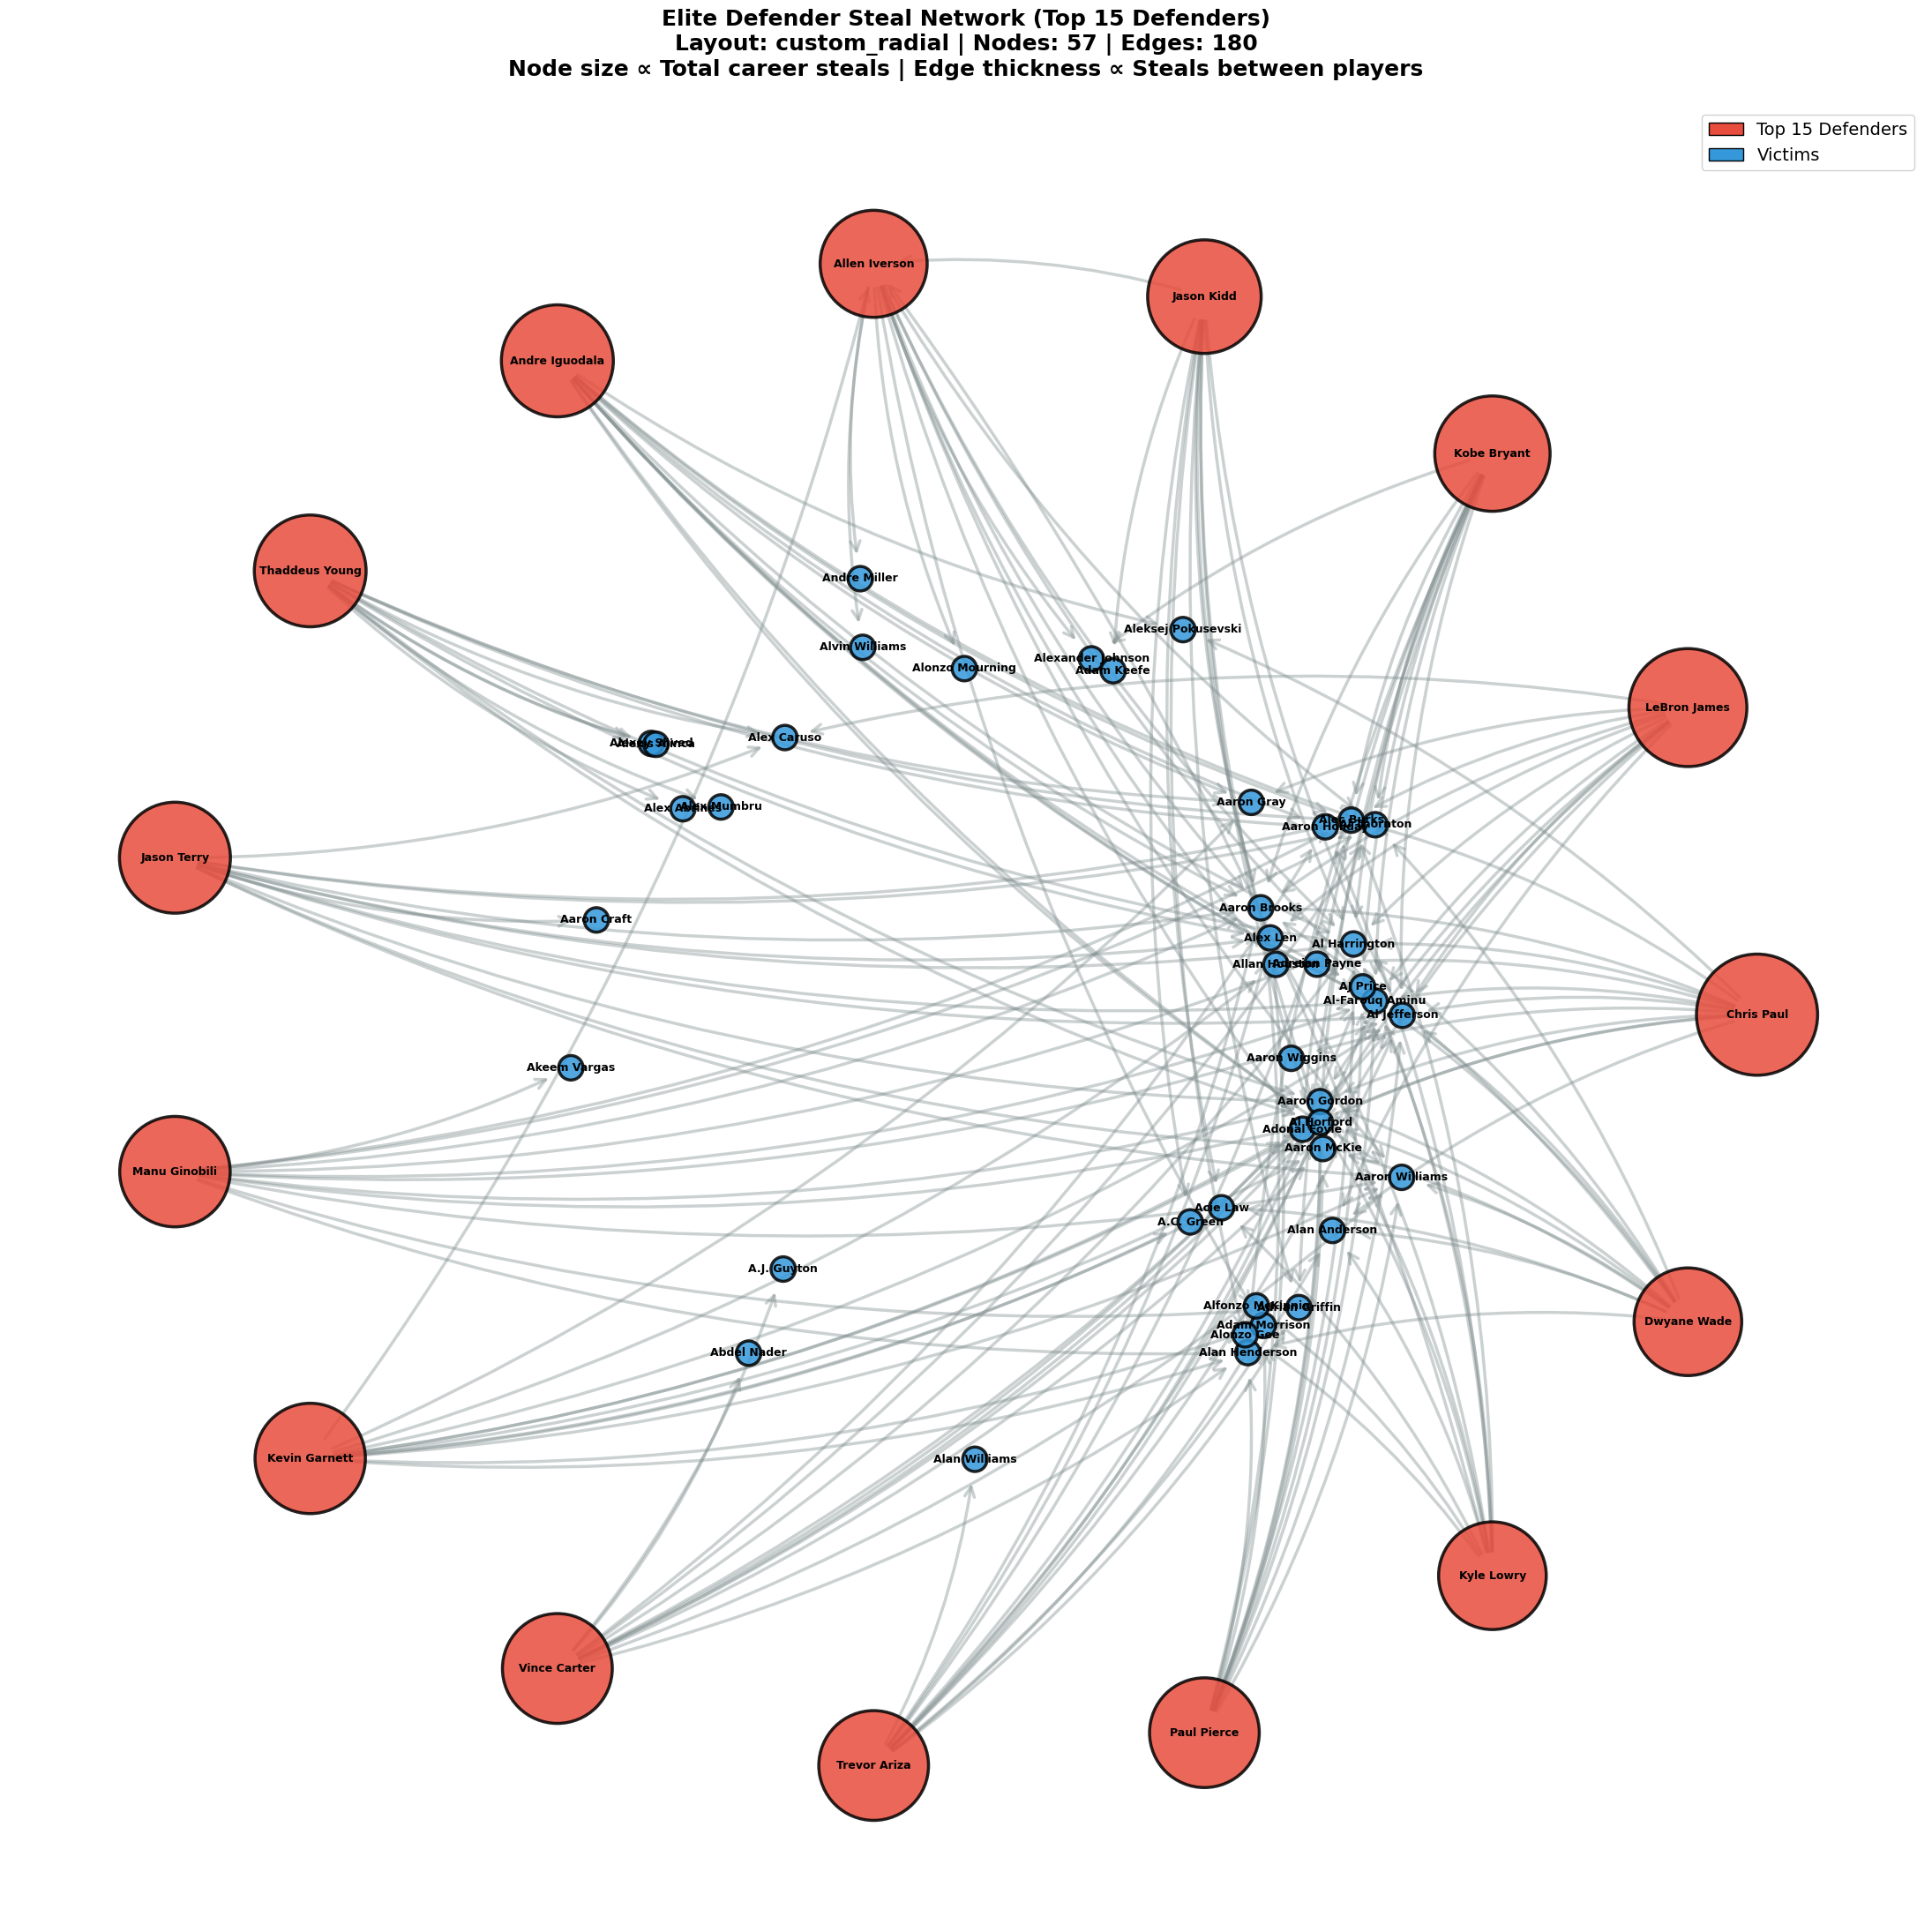


GENERATING INTERACTIVE VISUALIZATION...

✅ Interactive visualization saved as 'steal_network_custom_radial_interactive.html'
✅ Static visualization saved as 'steal_network_custom_radial.png'



TIP: Try different layouts by changing LAYOUT_TYPE:
  • 'custom_radial' - Defenders in outer ring (RECOMMENDED)
  • 'bipartite' - Defenders left, victims right
  • 'shell' - Multiple concentric shells
  • 'force_separated' - Force-directed with separation
  • 'spring' - Classic force-directed
  • 'kamada' - Kamada-Kawai algorithm


In [20]:
# ============================================================
# Enhanced Optimal Steal Network with Better Node Distribution
# ============================================================
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from matplotlib.patches import Patch
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================
# TOP_STEALERS = 15            # focus on elite defenders
# MAX_VICTIMS_PER_DEFENDER = 12  # cap clutter per defender
# MIN_EDGE_WEIGHT = 1          # minimum steals to show edge
# SHOW_EDGE_LABELS_THRESHOLD = 2  # only label edges with 2+ steals

# # Layout configuration - experiment with these!
# LAYOUT_TYPE = 'custom_radial'  # Options: 'spring', 'kamada', 'custom_radial', 'shell', 'bipartite'
# SPRING_K = 3.5                 # Higher = more spread (for spring layout)
# SPRING_ITERATIONS = 100        # More iterations = better convergence

# ============================================================
# DATA PREPARATION
# ============================================================
steal_edges = edge_df[edge_df["interaction"]=="steal"].copy()
top_defenders = steal_counts.head(TOP_STEALERS).index

# defender → victim grouped count
pair_counts = (
    steal_edges.groupby(["source","target"])
    .size()
    .reset_index(name="steal_count")
)

# keep only edges where source is top defender
pair_counts = pair_counts[pair_counts["source"].isin(top_defenders)]

# limit each defender to top 12 targets (reduces clutter)
filtered_pairs = []
for defender in top_defenders:
    df_def = pair_counts[pair_counts["source"] == defender]
    df_def = df_def.sort_values("steal_count", ascending=False).head(MAX_VICTIMS_PER_DEFENDER)
    filtered_pairs.append(df_def)

pair_counts = pd.concat(filtered_pairs, ignore_index=True)
pair_counts = pair_counts[pair_counts["steal_count"] >= MIN_EDGE_WEIGHT]

# ============================================================
# BUILD GRAPH
# ============================================================
G = nx.DiGraph()
for _, row in pair_counts.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["steal_count"])

print("=" * 60)
print("NETWORK STATISTICS")
print("=" * 60)
print(f"Total Nodes: {len(G.nodes())}")
print(f"Total Edges: {len(G.edges())}")
print(f"Defenders: {len([n for n in G.nodes() if n in top_defenders])}")
print(f"Victims: {len([n for n in G.nodes() if n not in top_defenders])}")

# Most victimized players
victim_counts = dict(G.in_degree(weight='weight'))
print(f"\nTOP 10 MOST STOLEN FROM:")
for player, count in sorted(victim_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    defenders_count = G.in_degree(player)
    print(f"  {player}: {count} steals (by {defenders_count} defenders)")

# ============================================================
# CUSTOM LAYOUT ALGORITHMS TO PREVENT GROUPING
# ============================================================

def custom_radial_layout(G, top_defenders):
    """
    Place defenders in outer ring, victims in inner areas
    This prevents defender grouping
    """
    pos = {}
    
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    # Place defenders in a circle
    n_defenders = len(defenders)
    for i, defender in enumerate(defenders):
        angle = 2 * np.pi * i / n_defenders
        radius = 10  # outer ring
        pos[defender] = (radius * np.cos(angle), radius * np.sin(angle))
    
    # Place victims in inner regions, clustered near their main defender
    for victim in victims:
        # Find which defenders steal from this victim
        stealing_defenders = list(G.predecessors(victim))
        
        if stealing_defenders:
            # Calculate average position of stealing defenders
            avg_angle = 0
            total_weight = 0
            
            for defender in stealing_defenders:
                if defender in pos:
                    defender_angle = np.arctan2(pos[defender][1], pos[defender][0])
                    weight = G[defender][victim]['weight']
                    avg_angle += defender_angle * weight
                    total_weight += weight
            
            if total_weight > 0:
                avg_angle /= total_weight
                
                # Add some randomness to prevent exact overlap
                angle_jitter = (np.random.random() - 0.5) * 0.3
                radius_jitter = np.random.random() * 2
                
                # Place victim closer to center, near their defenders
                inner_radius = 4 + radius_jitter
                pos[victim] = (
                    inner_radius * np.cos(avg_angle + angle_jitter),
                    inner_radius * np.sin(avg_angle + angle_jitter)
                )
        else:
            # Fallback for victims with no defenders
            angle = np.random.random() * 2 * np.pi
            radius = np.random.random() * 3 + 3
            pos[victim] = (radius * np.cos(angle), radius * np.sin(angle))
    
    return pos

def bipartite_style_layout(G, top_defenders):
    """
    Defenders on left, victims on right
    """
    pos = {}
    
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    # Place defenders vertically on the left
    n_defenders = len(defenders)
    for i, defender in enumerate(defenders):
        y = (i - n_defenders/2) * 2
        x = -10
        pos[defender] = (x, y)
    
    # Place victims vertically on the right
    n_victims = len(victims)
    for i, victim in enumerate(victims):
        y = (i - n_victims/2) * (n_defenders * 2 / n_victims) if n_victims > 0 else 0
        x = 10
        # Add slight jitter
        pos[victim] = (x + np.random.randn() * 0.5, y + np.random.randn() * 0.3)
    
    return pos

def shell_layout_separated(G, top_defenders):
    """
    Multiple shells with defenders separated
    """
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    # Create shells: defenders on outer shell, victims on inner shells
    shells = [defenders]
    
    # Divide victims into multiple shells by how many defenders steal from them
    victim_popularity = {v: G.in_degree(v) for v in victims}
    sorted_victims = sorted(victims, key=lambda v: victim_popularity[v], reverse=True)
    
    # Create 2-3 inner shells
    n_victims = len(sorted_victims)
    if n_victims > 0:
        shell_size = max(n_victims // 3, 1)
        for i in range(0, n_victims, shell_size):
            shells.append(sorted_victims[i:i+shell_size])
    
    return nx.shell_layout(G, shells)

def force_directed_separated(G, top_defenders):
    """
    Force-directed with initial positions to separate defenders
    """
    # Start with defenders evenly spaced
    initial_pos = {}
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    n_defenders = len(defenders)
    for i, defender in enumerate(defenders):
        angle = 2 * np.pi * i / n_defenders
        initial_pos[defender] = np.array([15 * np.cos(angle), 15 * np.sin(angle)])
    
    # Place victims randomly in center
    for victim in victims:
        angle = np.random.random() * 2 * np.pi
        radius = np.random.random() * 5
        initial_pos[victim] = np.array([radius * np.cos(angle), radius * np.sin(angle)])
    
    # Run spring layout with initial positions
    return nx.spring_layout(G, pos=initial_pos, k=SPRING_K, iterations=SPRING_ITERATIONS, seed=42)

# ============================================================
# SELECT AND APPLY LAYOUT
# ============================================================
print(f"\nUsing layout: {LAYOUT_TYPE}")

if LAYOUT_TYPE == 'spring':
    pos = nx.spring_layout(G, k=SPRING_K, iterations=SPRING_ITERATIONS, seed=42)
elif LAYOUT_TYPE == 'kamada':
    pos = nx.kamada_kawai_layout(G)
elif LAYOUT_TYPE == 'custom_radial':
    pos = custom_radial_layout(G, top_defenders)
elif LAYOUT_TYPE == 'shell':
    pos = shell_layout_separated(G, top_defenders)
elif LAYOUT_TYPE == 'bipartite':
    pos = bipartite_style_layout(G, top_defenders)
elif LAYOUT_TYPE == 'force_separated':
    pos = force_directed_separated(G, top_defenders)
else:
    # Default fallback
    pos = nx.spring_layout(G, k=3.0, iterations=100, seed=42)

# ============================================================
# MATPLOTLIB VISUALIZATION
# ============================================================
plt.figure(figsize=(22, 22))

# Node sizing based on total steals
node_sizes = []
for node in G.nodes():
    size = steal_counts.get(node, 0) * 15
    node_sizes.append(max(size, 400))

# Color defenders vs victims differently
node_colors = ['#e74c3c' if node in top_defenders else '#3498db' 
               for node in G.nodes()]

# Edge weights
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights) if edge_weights else 1
min_weight = min(edge_weights) if edge_weights else 1

# Draw edges with curved arrows and scaled widths
if max_weight > min_weight:
    edge_widths = [0.5 + ((w - min_weight) / (max_weight - min_weight)) * 4.5 for w in edge_weights]
else:
    edge_widths = [2.5] * len(edge_weights)

nx.draw_networkx_edges(
    G, pos, 
    width=edge_widths,
    alpha=0.4,
    arrowsize=20,
    arrowstyle='->',
    connectionstyle='arc3,rad=0.1',
    edge_color='#7f8c8d',
    min_source_margin=20,
    min_target_margin=20
)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.85,
    edgecolors='black',
    linewidths=2.5
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_family='sans-serif')

# Add edge labels for high-value connections only
edge_labels = {(u, v): f"{G[u][v]['weight']}" 
               for u, v in G.edges() if G[u][v]['weight'] >= SHOW_EDGE_LABELS_THRESHOLD}
if edge_labels:
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, 
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Add legend
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label=f'Top {TOP_STEALERS} Defenders'),
    Patch(facecolor='#3498db', edgecolor='black', label='Victims')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=14, framealpha=0.9)

# Title with statistics
plt.title(
    f"Elite Defender Steal Network (Top {TOP_STEALERS} Defenders)\n"
    f"Layout: {LAYOUT_TYPE} | Nodes: {len(G.nodes())} | Edges: {len(G.edges())}\n"
    f"Node size ∝ Total career steals | Edge thickness ∝ Steals between players", 
    fontsize=18, pad=25, fontweight='bold'
)

plt.axis("off")
plt.tight_layout()
plt.savefig(f'steal_network_{LAYOUT_TYPE}.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================
# INTERACTIVE PLOTLY VISUALIZATION
# ============================================================
print("\n" + "=" * 60)
print("GENERATING INTERACTIVE VISUALIZATION...")
print("=" * 60)

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = G[edge[0]][edge[1]]['weight']
    
    if max_weight > min_weight:
        scaled_width = 0.5 + ((weight - min_weight) / (max_weight - min_weight)) * 5
    else:
        scaled_width = 3
    
    edge_traces.append(go.Scatter(
        x=[x0, x1, None], 
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=scaled_width, color='rgba(127, 140, 141, 0.5)'),
        hoverinfo='text',
        hovertext=f"<b>{edge[0]} → {edge[1]}</b><br>{weight} steal(s)",
        showlegend=False
    ))

# Create node trace
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_text = [node for node in G.nodes()]

# Prepare hover text
hover_texts = []
for node in G.nodes():
    total_steals = steal_counts.get(node, 0)
    is_defender = node in top_defenders
    
    if is_defender:
        out_degree = G.out_degree(node, weight='weight')
        victims = G.out_degree(node)
        in_degree = G.in_degree(node, weight='weight')
        
        hover_texts.append(
            f"<b>{node}</b> (DEFENDER)<br>"
            f"─────────────────<br>"
            f"Total Career Steals: {total_steals}<br>"
            f"Steals in Network: {out_degree}<br>"
            f"Victims Targeted: {victims}"
        )
    else:
        in_degree = G.in_degree(node, weight='weight')
        stolen_by = G.in_degree(node)
        
        hover_texts.append(
            f"<b>{node}</b> (VICTIM)<br>"
            f"─────────────────<br>"
            f"Total Career Steals: {total_steals}<br>"
            f"Stolen from: {in_degree} times<br>"
            f"By {stolen_by} defenders"
        )

plotly_node_colors = ['#e74c3c' if node in top_defenders else '#3498db' 
                      for node in G.nodes()]

plotly_node_sizes = []
for node in G.nodes():
    size = steal_counts.get(node, 0) * 0.8
    plotly_node_sizes.append(max(size, 20))

node_trace = go.Scatter(
    x=node_x, 
    y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    textfont=dict(size=10, color='black', family='Arial Black'),
    marker=dict(
        size=plotly_node_sizes,
        color=plotly_node_colors,
        line=dict(width=2, color='black'),
        opacity=0.9
    ),
    hovertext=hover_texts,
    hoverinfo='text',
    showlegend=False
)

fig = go.Figure(data=edge_traces + [node_trace])

fig.update_layout(
    title=dict(
        text=f"<b>Elite Defender Steal Network (Interactive)</b><br>"
             f"<sub>Layout: {LAYOUT_TYPE} | Top {TOP_STEALERS} Defenders</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    showlegend=False,
    width=1600,
    height=1600,
    hovermode='closest',
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=[
        dict(
            text="🔴 Red = Defenders | 🔵 Blue = Victims<br>Hover for details | Drag to pan | Scroll to zoom",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.5, y=-0.05,
            xanchor='center',
            font=dict(size=12)
        )
    ]
)

fig.write_html(f'steal_network_{LAYOUT_TYPE}_interactive.html')
print(f"\n✅ Interactive visualization saved as 'steal_network_{LAYOUT_TYPE}_interactive.html'")
print(f"✅ Static visualization saved as 'steal_network_{LAYOUT_TYPE}.png'")

fig.show()

print("\n" + "=" * 60)
print("TIP: Try different layouts by changing LAYOUT_TYPE:")
print("  • 'custom_radial' - Defenders in outer ring (RECOMMENDED)")
print("  • 'bipartite' - Defenders left, victims right")
print("  • 'shell' - Multiple concentric shells")
print("  • 'force_separated' - Force-directed with separation")
print("  • 'spring' - Classic force-directed")
print("  • 'kamada' - Kamada-Kawai algorithm")
print("=" * 60)

Nodes: 57
Edges: 180


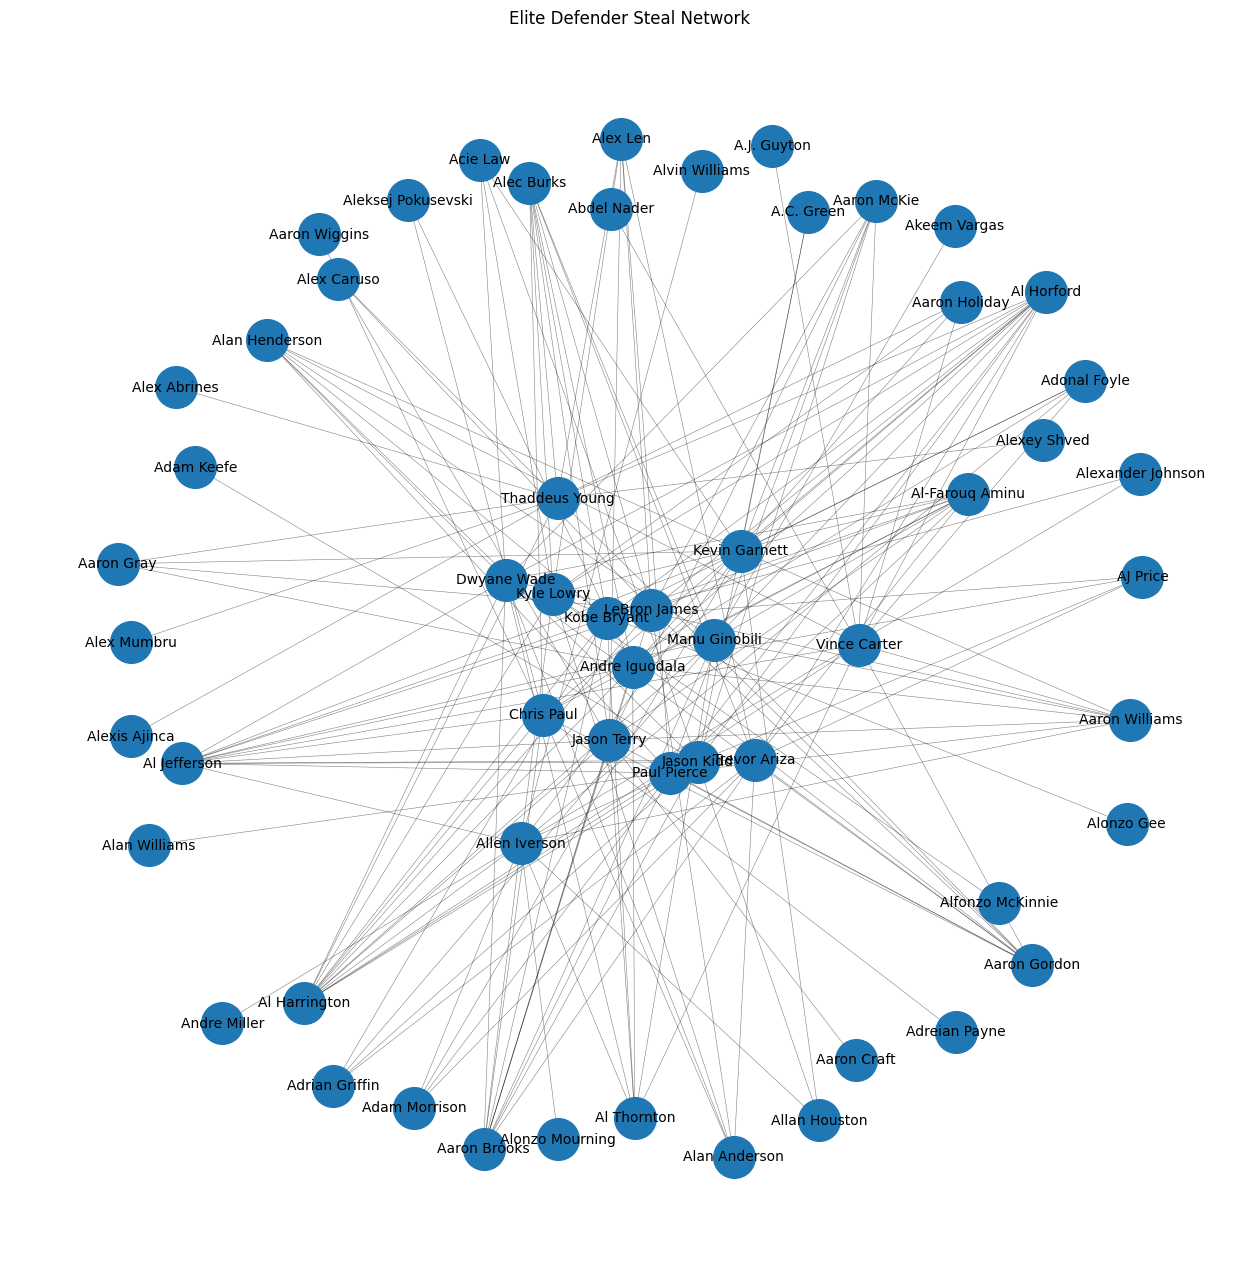

In [19]:
# ============================================================
# Optimal Balanced Steal Network
# ============================================================

import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

TOP_STEALERS = 15            # focus on elite defenders
MAX_VICTIMS_PER_DEFENDER = 12  # cap clutter
MIN_STEALS_VS_PLAYER = 1     # allow single-steal but limit count

steal_edges = edge_df[edge_df["interaction"]=="steal"]

top_defenders = steal_counts.head(TOP_STEALERS).index

# defender → victim grouped count
pair_counts = (
    steal_edges.groupby(["source","target"])
    .size()
    .reset_index(name="steal_count")
)

# keep only edges where source is top defender
pair_counts = pair_counts[pair_counts["source"].isin(top_defenders)]

# limit each defender to top 12 targets (reduces clutter)
filtered_pairs = []
for defender in top_defenders:
    df_def = pair_counts[pair_counts["source"] == defender]
    df_def = df_def.sort_values("steal_count", ascending=False).head(MAX_VICTIMS_PER_DEFENDER)
    filtered_pairs.append(df_def)

pair_counts = pd.concat(filtered_pairs)

# build graph
G = nx.DiGraph()
for _,row in pair_counts.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["steal_count"])

print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))

# draw
plt.figure(figsize=(16,16))
pos = nx.spring_layout(G, k=1.4)

edge_w = [G[u][v]["weight"] for u,v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=900)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, width=[w*0.4 for w in edge_w], alpha=0.5)

plt.title("Elite Defender Steal Network")
plt.axis("off")
plt.show()


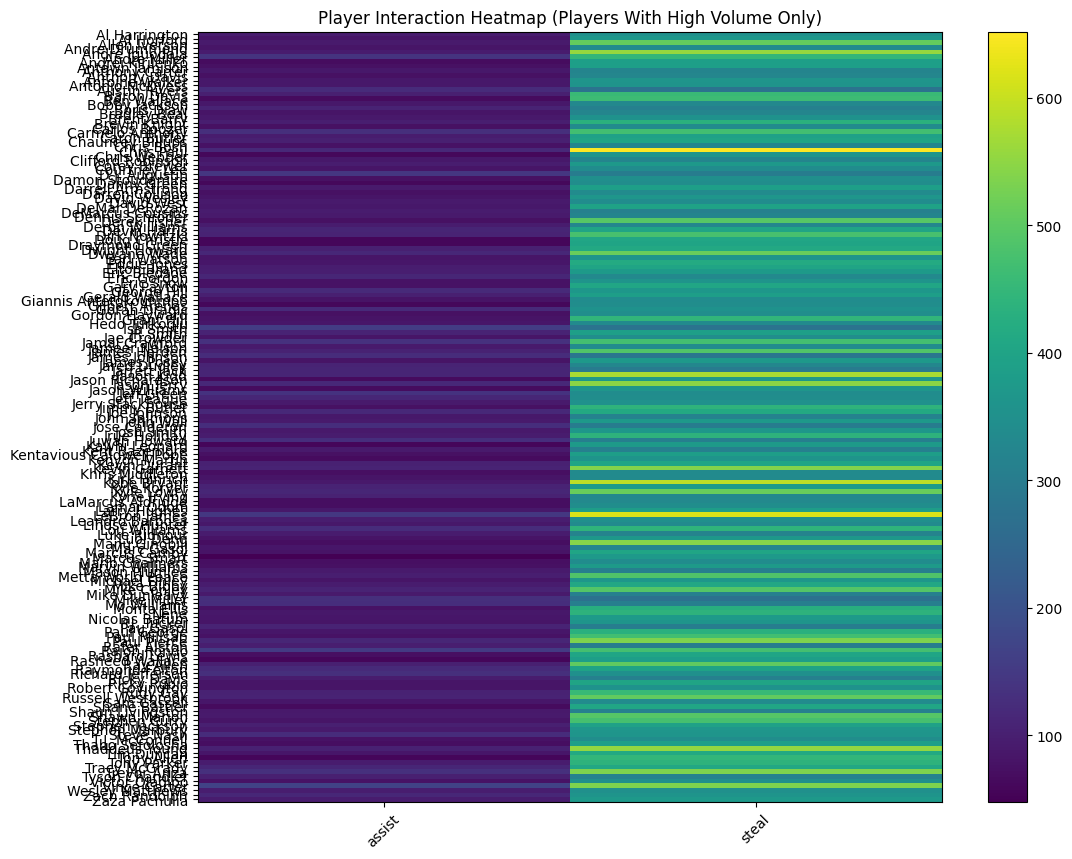

In [21]:
# ===== FILTER: ONLY PLAYERS WITH >= MIN_INTERACTIONS =====

MIN_INTERACTIONS = 400

valid_sources = (
    edge_df.groupby("source")
    .size()
    .reset_index(name="count")
)
valid_sources = valid_sources[valid_sources["count"] >= MIN_INTERACTIONS]["source"]

filtered = edge_df[edge_df["source"].isin(valid_sources)]

pivot = filtered.pivot_table(
    index="source",
    columns="interaction",
    aggfunc="size",
    fill_value=0
)

plt.figure(figsize=(12,10))
plt.imshow(pivot, aspect="auto")
plt.colorbar()
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Player Interaction Heatmap (Players With High Volume Only)")
plt.show()


In [15]:
# ============================================================
# SHOT-MAKE CLASSIFIER (LOGISTIC REGRESSION)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# clean dataset
model_df = shot_chart.copy()

# target: 1 if make, 0 if miss
model_df["is_make"] = model_df["event_class"].eq("shot_make").astype(int)

# remove NaN distances
model_df = model_df.dropna(subset=["shot_distance"])

# features:
# - shot_distance (numeric)
# - shooter (categorical: high-cardinality → one-hot)
X_num = model_df[["shot_distance"]]

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(model_df[["shooter"]])

# combine numeric + categorical
X = np.hstack([X_num.values, X_cat])
y = model_df["is_make"].values

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# evaluation
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print("Shot-Make Model Accuracy:", acc)
print("Shot-Make Model AUC:", auc)
print("Number of Players Encoded:", X_cat.shape[1])


MemoryError: Unable to allocate 81.8 GiB for an array with shape (3878244, 2830) and data type float64

In [ ]:
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# clean
model_df = shot_chart.copy()
model_df["is_make"] = (model_df["event_class"] == "shot_make").astype(int)
model_df = model_df.dropna(subset=["shot_distance"])

model_df["shooter_fg_pct"] = (
    model_df.groupby("shooter")["is_make"].transform("mean")
)

model_df["dist_x_fg"] = model_df["shot_distance"] * model_df["shooter_fg_pct"]



# numeric
X_num = model_df[["shot_distance"]].values  # this is small

# categorical (sparse!)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = enc.fit_transform(model_df[["shooter"]])

# combine (sparse matrix)
X = hstack([X_num, X_cat]).tocsr()

y = model_df["is_make"].values

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# logistic regression for sparse input
# model = LogisticRegression(
#     max_iter=200,
#     solver="liblinear"   # works well with sparse binary features
# )
# model.fit(X_train, y_train)

model = LogisticRegression(
    max_iter=500,
    solver="saga",
    penalty="elasticnet",
    l1_ratio=0.3,
    verbose=1
)
model.fit(X_train, y_train)


# evaluate
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

print("acc:", accuracy_score(y_test, pred))
print("auc:", roc_auc_score(y_test, proba))
print("num players:", X_cat.shape[1])


/home/gywn908/anaconda3/envs/popl25/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Epoch 1, change: 1
Epoch 2, change: 0.04196246
Epoch 3, change: 0.036926999
Epoch 4, change: 0.035509526
Epoch 5, change: 0.03355878


In [31]:
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# clean
model_df = shot_chart.copy()
model_df["is_make"] = (model_df["event_class"] == "shot_make").astype(int)
model_df = model_df.dropna(subset=["shot_distance"])

model_df["shooter_fg_pct"] = (
    model_df.groupby("shooter")["is_make"].transform("mean")
)

model_df["dist_x_fg"] = model_df["shot_distance"] * model_df["shooter_fg_pct"]



# numeric
X_num = model_df[["shot_distance"]].values  # this is small

# categorical (sparse!)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = enc.fit_transform(model_df[["shooter"]])

# combine (sparse matrix)
X = hstack([X_num, X_cat]).tocsr()

y = model_df["is_make"].values

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y)


ValueError: Found input variables with inconsistent numbers of samples: [3102595, 3878244]

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm import tqdm

model = LogisticRegression(
    solver="saga",
    penalty="elasticnet",
    l1_ratio=0.3,
    max_iter=1,        # one iteration per fit
    warm_start=True
)

best_loss = np.inf
patience = 10
patience_counter = 0
max_iters = 500

for i in tqdm(range(max_iters)):
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict_proba(X_val)
    val_loss = log_loss(y_val, y_pred)

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Stopping early at iteration {i}")
        break

model = best_model  # restore the best model


  0%|          | 0/500 [00:00<?, ?it/s]/home/gywn908/anaconda3/envs/popl25/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/gywn908/anaconda3/envs/popl25/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 0/500 [00:25<?, ?it/s]


NameError: name 'X_val' is not defined

In [28]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6205190 stored elements and shape (3102595, 2831)>

In [29]:
y_train

array([0, 0, 0, ..., 0, 1, 0], shape=(3102595,))

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from tqdm import tqdm



model = LogisticRegression(
    solver="saga",
    penalty="elasticnet",
    l1_ratio=0.3,
    max_iter=1,        # one iteration per fit
    warm_start=True
)

best_loss = np.inf
patience = 10
patience_counter = 0
max_iters = 500

for i in tqdm(range(max_iters)):
    model.fit(X_train_1, y_train_1)

    # Predict on validation set
    y_pred = model.predict_proba(X_val)
    val_loss = log_loss(y_val, y_pred)

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            l1_ratio=0.3,
            max_iter=1,
            warm_start=True
        )
        best_model.coef_ = model.coef_.copy()
        best_model.intercept_ = model.intercept_.copy()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Stopping early at iteration {i}")
        break

model = best_model  # restore the best model


ValueError: Found input variables with inconsistent numbers of samples: [3102595, 3878244]

In [2]:
shot_chart = pd.read_parquet("./parquet/clean_shot_data.parquet")

In [19]:
df = pd.read_parquet("./parquet/play_by_play.parquet")

In [20]:
shot_chart.columns

Index(['shooter', 'event_class', 'shot_distance', 'homedescription',
       'visitordescription', 'possession_id'],
      dtype='object')

In [21]:
df.columns

Index(['game_id', 'eventnum', 'eventmsgtype', 'eventmsgactiontype', 'period',
       'wctimestring', 'pctimestring', 'homedescription', 'neutraldescription',
       'visitordescription', 'score', 'scoremargin', 'person1type',
       'player1_id', 'player1_name', 'player1_team_id', 'player1_team_city',
       'player1_team_nickname', 'player1_team_abbreviation', 'person2type',
       'player2_id', 'player2_name', 'player2_team_id', 'player2_team_city',
       'player2_team_nickname', 'player2_team_abbreviation', 'person3type',
       'player3_id', 'player3_name', 'player3_team_id', 'player3_team_city',
       'player3_team_nickname', 'player3_team_abbreviation',
       'video_available_flag', 'event_class', 'possession_id', 'shot_distance',
       'shooter'],
      dtype='object')

In [3]:
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# clean
model_df = shot_chart.copy()
model_df["is_make"] = (model_df["event_class"] == "shot_make").astype(int)
model_df = model_df.dropna(subset=["shot_distance"])

model_df["shooter_fg_pct"] = (
    model_df.groupby("shooter")["is_make"].transform("mean")
)

model_df["dist_x_fg"] = model_df["shot_distance"] * model_df["shooter_fg_pct"]



# numeric
X_num = model_df[["shot_distance"]].values  # this is small

# categorical (sparse!)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = enc.fit_transform(model_df[["shooter"]])

# combine (sparse matrix)
X = hstack([X_num, X_cat]).tocsr()

y = model_df["is_make"].values

# split
x_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [4]:
import torch
import torch.nn as nn

class LogisticRegressionTorch(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [5]:
import torch

def scipy_to_torch_sparse(scipy_mat):
    mat = scipy_mat.tocoo()
    indices = torch.tensor(np.vstack((mat.row, mat.col)), dtype=torch.long)
    values = torch.tensor(mat.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, mat.shape).coalesce().cuda()

X_train_t = scipy_to_torch_sparse(X_train)
X_val_t   = scipy_to_torch_sparse(X_val)
y_train_t = torch.tensor(y_train, dtype=torch.float32).cuda()
y_val_t   = torch.tensor(y_val, dtype=torch.float32).cuda()


In [35]:
import torch
import sys

def calculate_dataset_size(dataset):
    total_size = 0
    for i in range(len(dataset)):
        # Get one item from the dataset
        item = dataset[i]
        
        # Function to recursively calculate size of tensors and other objects
        total_size += deep_getsizeof(item)
        
    # Convert bytes to a more readable format (MB, GB)
    # Note: this is a rough estimate and might not perfectly match actual allocated memory
    return total_size

def deep_getsizeof(obj, seen=None):
    """
    Recursively calculate the size of an object, including its contents, 
    and avoid double-counting shared objects.
    """
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)

    size = sys.getsizeof(obj)
    if isinstance(obj, torch.Tensor):
        # For tensors, the main memory is the underlying data
        size += obj.nelement() * obj.element_size()
    elif isinstance(obj, (list, tuple)):
        for item in obj:
            size += deep_getsizeof(item, seen)
    elif isinstance(obj, dict):
        for key, value in obj.items():
            size += deep_getsizeof(key, seen)
            size += deep_getsizeof(value, seen)
    # Add other container types (e.g., numpy arrays) if necessary

    return size

# Example usage with your dataset:
# dataset = YourCustomDataset(...) 
# estimated_bytes = calculate_dataset_size(dataset)
# estimated_gb = estimated_bytes / (1024**3)
# print(f"Estimated total dataset size: {estimated_gb:.2f} GB")


In [36]:
# X_train_t
# X_val_t
# y_train_t
# y_val_t

estimated_bytes = calculate_dataset_size(X_train_t)

KeyboardInterrupt: 

In [38]:
estimated_memory = torch.cuda.memory_allocated()

In [39]:
estimated_memory / (1024**3)

0.19298028945922852

In [6]:
import torch.optim as optim
from tqdm import tqdm

model = LogisticRegressionTorch(n_features=X_train.shape[1]).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

best_loss = float("inf")
patience = 5
patience_counter = 0
epochs = 200

for epoch in tqdm(range(epochs)):
    model.train()

    # forward pass
    pred = model(X_train_t).squeeze()
    loss = criterion(pred, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t).squeeze()
        val_loss = criterion(val_pred, y_val_t)

    # early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Stopping early at epoch {epoch}")
        break

# load best model
model.load_state_dict(best_weights)


100%|██████████| 200/200 [00:05<00:00, 38.69it/s]


<All keys matched successfully>

In [7]:
model.eval()

LogisticRegressionTorch(
  (linear): Linear(in_features=2831, out_features=1, bias=True)
)

In [11]:
X_test_t = scipy_to_torch_sparse(X_test)
y_test_t = torch.tensor(y_test, dtype=torch.float32).cuda()

In [13]:
with torch.no_grad():
    proba_test = model(X_test_t).squeeze().cpu().numpy() 
    y_test_proba = model(X_test_t).squeeze()
    y_test_pred = (y_test_proba >= 0.5).long()

from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(y_test, y_test_pred.cpu())
auc = roc_auc_score(y_test, y_test_proba.cpu())

print("Test Accuracy:", acc)
print("Test AUC:", auc)


Test Accuracy: 0.6077143140776304
Test AUC: 0.6071834841055375


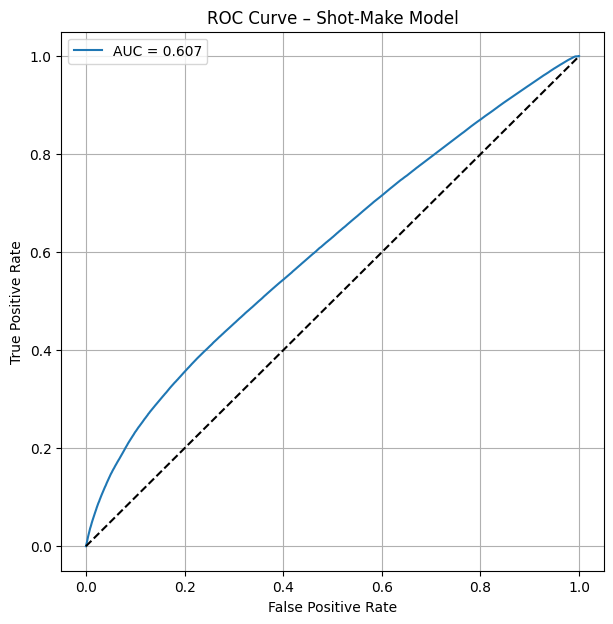

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_val = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f"AUC = {roc_val:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


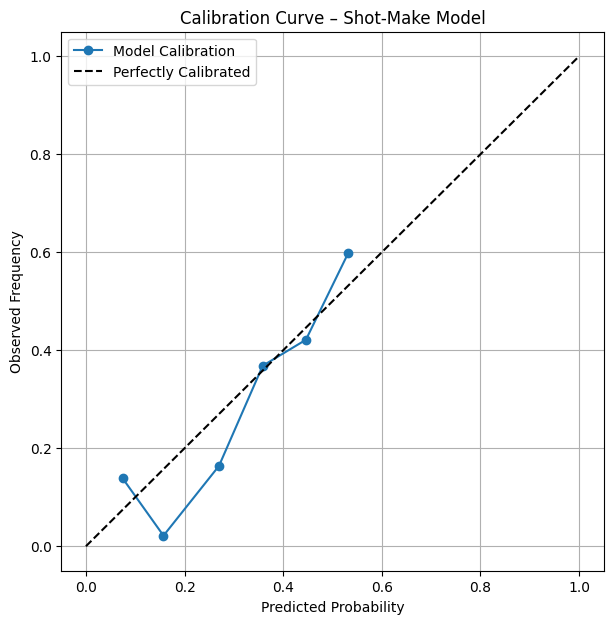

In [15]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)

plt.figure(figsize=(7,7))
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0,1],[0,1],'k--', label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm


In [17]:
class ShotDataset(Dataset):
    def __init__(self, shooter_ids, numeric_feats, labels):
        self.shooter_ids = torch.tensor(shooter_ids, dtype=torch.long)
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.shooter_ids[idx], self.numeric_feats[idx], self.labels[idx]


In [18]:
class ShotMakeMLP(nn.Module):
    def __init__(self, num_shooters, embed_dim, num_numeric_feats, hidden_dims=[64,32]):
        super().__init__()
        self.embedding = nn.Embedding(num_shooters, embed_dim)
        input_dim = embed_dim + num_numeric_feats
        
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(0.2))
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))  # single output for logistic
        self.mlp = nn.Sequential(*layers)

    def forward(self, shooter_id, numeric_feats):
        x_embed = self.embedding(shooter_id)
        x = torch.cat([x_embed, numeric_feats], dim=1)
        x = self.mlp(x)
        return torch.sigmoid(x).squeeze()


In [33]:
# Sort shots by shooter and possession_id
model_df = model_df.sort_values(["shooter", "possession_id"])

# Rolling 5-shot success rate
model_df["shooter_last5_fg"] = (
    model_df.groupby("shooter")["event_class"]
            .apply(lambda x: x.eq("shot_make").rolling(5, min_periods=1).mean())
)


TypeError: incompatible index of inserted column with frame index

In [22]:
# Example: only numeric feature is shot_distance
numeric_features = model_df[["shot_distance"]].values.astype(np.float32)
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

# Map shooters to integer IDs
shooter2id = {name:i for i,name in enumerate(model_df["shooter"].unique())}
shooter_ids = model_df["shooter"].map(shooter2id).values

# Labels
labels = model_df["is_make"].values.astype(np.float32)

# Train / validation / test split
X_train_ids, X_test_ids, X_train_num, X_test_num, y_train, y_test = train_test_split(
    shooter_ids, numeric_features, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train_ids, X_val_ids, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_train_ids, X_train_num, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [23]:
batch_size = 1024

train_dataset = ShotDataset(X_train_ids, X_train_num, y_train)
val_dataset = ShotDataset(X_val_ids, X_val_num, y_val)
test_dataset = ShotDataset(X_test_ids, X_test_num, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ShotMakeMLP(
    num_shooters=len(shooter2id),
    embed_dim=16,
    num_numeric_feats=X_train_num.shape[1],
    hidden_dims=[64,32]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

best_val_loss = float("inf")
patience = 5
patience_counter = 0
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for shooter_batch, num_batch, label_batch in train_loader:
        shooter_batch = shooter_batch.to(device)
        num_batch = num_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        pred = model(shooter_batch, num_batch)
        loss = criterion(pred, label_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(label_batch)

    train_loss /= len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for shooter_batch, num_batch, label_batch in val_loader:
            shooter_batch = shooter_batch.to(device)
            num_batch = num_batch.to(device)
            label_batch = label_batch.to(device)
            pred = model(shooter_batch, num_batch)
            loss = criterion(pred, label_batch)
            val_loss += loss.item() * len(label_batch)
    val_loss /= len(val_dataset)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

model.load_state_dict(best_weights)


Epoch 1 - Train Loss: 0.6656 - Val Loss: 0.6603
Epoch 2 - Train Loss: 0.6607 - Val Loss: 0.6594
Epoch 3 - Train Loss: 0.6598 - Val Loss: 0.6594
Epoch 4 - Train Loss: 0.6593 - Val Loss: 0.6589
Epoch 5 - Train Loss: 0.6589 - Val Loss: 0.6584
Epoch 6 - Train Loss: 0.6586 - Val Loss: 0.6582
Epoch 7 - Train Loss: 0.6582 - Val Loss: 0.6584
Epoch 8 - Train Loss: 0.6581 - Val Loss: 0.6579
Epoch 9 - Train Loss: 0.6579 - Val Loss: 0.6579
Epoch 10 - Train Loss: 0.6577 - Val Loss: 0.6578
Epoch 11 - Train Loss: 0.6576 - Val Loss: 0.6579
Epoch 12 - Train Loss: 0.6575 - Val Loss: 0.6577
Epoch 13 - Train Loss: 0.6574 - Val Loss: 0.6577
Epoch 14 - Train Loss: 0.6572 - Val Loss: 0.6579
Epoch 15 - Train Loss: 0.6572 - Val Loss: 0.6576
Epoch 16 - Train Loss: 0.6572 - Val Loss: 0.6575
Epoch 17 - Train Loss: 0.6570 - Val Loss: 0.6576
Epoch 18 - Train Loss: 0.6570 - Val Loss: 0.6575
Epoch 19 - Train Loss: 0.6568 - Val Loss: 0.6576
Epoch 20 - Train Loss: 0.6569 - Val Loss: 0.6575
Epoch 21 - Train Loss: 0.6568

<All keys matched successfully>

In [26]:
model.eval()
proba_test = []

with torch.no_grad():
    for shooter_batch, num_batch, _ in test_loader:
        shooter_batch = shooter_batch.to(device)
        num_batch = num_batch.to(device)
        pred = model(shooter_batch, num_batch)
        proba_test.append(pred.cpu().numpy())

proba_test = np.concatenate(proba_test)
y_pred_test = (proba_test >= 0.5).astype(int)


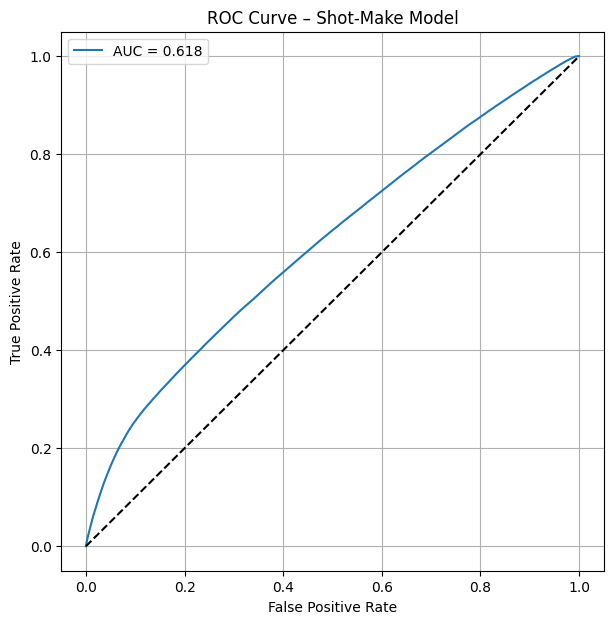

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_val = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f"AUC = {roc_val:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


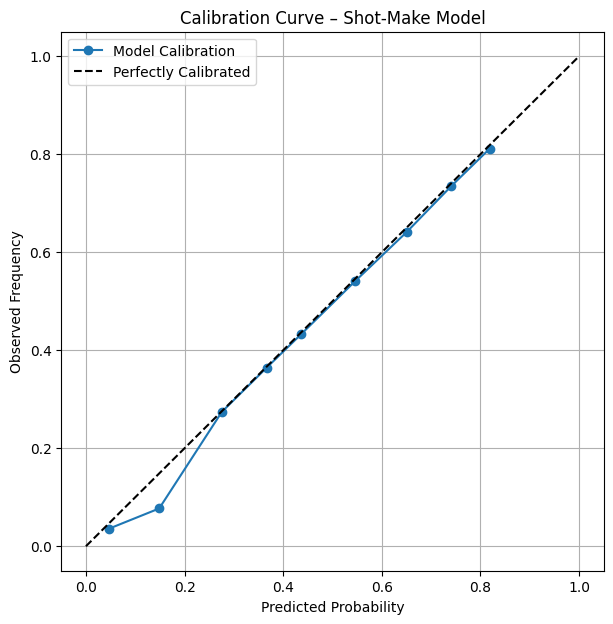

In [28]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)

plt.figure(figsize=(7,7))
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0,1],[0,1],'k--', label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score

# y_test should be a NumPy array of true labels
# If it's still a torch tensor, convert: y_test_np = y_test.cpu().numpy()
y_test_np = np.array(y_test)  # or y_test.values if it's a pandas Series

# Accuracy
acc = accuracy_score(y_test_np, y_pred_test)

# AUC (from probabilities)
auc_val = roc_auc_score(y_test_np, proba_test)

print(f"Test Accuracy: {acc:.3f}")
print(f"Test AUC: {auc_val:.3f}")


Test Accuracy: 0.618
Test AUC: 0.618


In [34]:
torch.save(model, "shot_mlp_full.pth")

In [31]:
df.columns

Index(['game_id', 'eventnum', 'eventmsgtype', 'eventmsgactiontype', 'period',
       'wctimestring', 'pctimestring', 'homedescription', 'neutraldescription',
       'visitordescription', 'score', 'scoremargin', 'person1type',
       'player1_id', 'player1_name', 'player1_team_id', 'player1_team_city',
       'player1_team_nickname', 'player1_team_abbreviation', 'person2type',
       'player2_id', 'player2_name', 'player2_team_id', 'player2_team_city',
       'player2_team_nickname', 'player2_team_abbreviation', 'person3type',
       'player3_id', 'player3_name', 'player3_team_id', 'player3_team_city',
       'player3_team_nickname', 'player3_team_abbreviation',
       'video_available_flag', 'event_class', 'possession_id', 'shot_distance',
       'shooter'],
      dtype='object')

In [32]:
shot_chart.head(20)


shooter event_class  shot_distance  \
0        Sam Cassell   shot_miss           15.0   
1    Cedric Ceballos   shot_miss           26.0   
2    Cedric Ceballos   shot_miss            1.0   
3   Shaquille O'Neal   shot_make            NaN   
4         Joe Kleine   shot_miss           11.0   
5    Cedric Ceballos   shot_make            NaN   
6      Wesley Person   shot_miss           16.0   
7      Wesley Person   shot_miss            NaN   
8    Cedric Ceballos   shot_miss            NaN   
9      Wesley Person   shot_make            NaN   
10        Joe Kleine   shot_miss           14.0   
11  Shaquille O'Neal   shot_make            NaN   
12      Robert Horry   shot_miss            NaN   
13   Cedric Ceballos   shot_make            NaN   
14      Derek Fisher   shot_make           25.0   
15       Sam Cassell   shot_make           15.0   
16       Eddie Jones   shot_make           24.0   
17        A.C. Green   shot_miss           18.0   
18    Elden Campbell   shot_make           14.0   
19        A.C. Green   shot_miss           11.0   

                                      homedescription  \
0                                                None   
1                     MISS Ceballos 26' 3PT Jump Shot   
2                              MISS Ceballos 1' Layup   
3          O'Neal  Slam Dunk (2 PTS) (Van Exel 1 AST)   
4                                                None   
5               Ceballos  Layup (2 PTS) (Jones 1 AST)   
6                                                None   
7                                                None   
8                                MISS Ceballos  Layup   
9                                                None   
10                                               None   
11          O'Neal 7' Hook Shot (4 PTS) (Jones 2 AST)   
12                             Ceballos BLOCK (1 BLK)   
13             Ceballos  Layup (4 PTS) (Fisher 1 AST)   
14  Fisher 25' 3PT Jump Shot (3 PTS) (Campbell 1 AST)   
15                                               None   
16     Jones 24' 3PT Jump Shot (3 PTS) (O'Neal 1 AST)   
17                                               None   
18      Campbell 14' Jump Shot (3 PTS) (Fisher 2 AST)   
19                                               None   

                             visitordescription  possession_id  
0                    MISS Cassell 15' Jump Shot              0  
1                                          None              1  
2                           Horry BLOCK (1 BLK)              3  
3                                          None              6  
4                     MISS Kleine 11' Jump Shot              7  
5                                          None              8  
6                     MISS Person 16' Jump Shot              9  
7                    MISS Person  3PT Jump Shot              9  
8                           Green BLOCK (1 BLK)             11  
9          Person  Layup (2 PTS) (Kleine 1 AST)             12  
10                    MISS Kleine 14' Jump Shot             13  
11                                         None             15  
12                            MISS Horry  Layup             16  
13                                         None             17  
14                                         None             18  
15  Cassell 15' Jump Shot (4 PTS) (Green 1 AST)             19  
16                                         None             20  
17                     MISS Green 18' Jump Shot             21  
18                                         None             22  
19                     MISS Green 11' Jump Shot             23

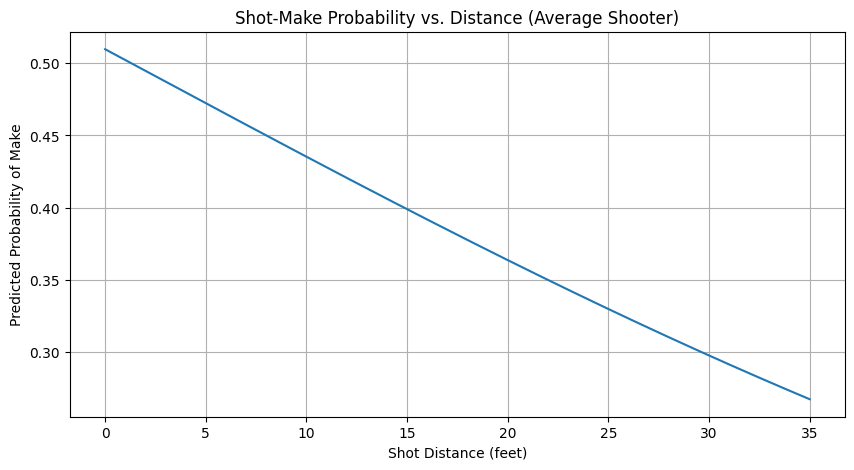

In [33]:
# ============================================================
# P(make) vs Shot Distance
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Create a smooth distance range
dist_range = np.linspace(0, 35, 200).reshape(-1, 1)

# Encode shooter as "average player" (all zeros)
zero_shooter = np.zeros((dist_range.shape[0], X_cat.shape[1]))

# combined feature vector
X_plot = np.hstack([dist_range, zero_shooter])

proba = model.predict_proba(X_plot)[:,1]

plt.figure(figsize=(10,5))
plt.plot(dist_range, proba)
plt.xlabel("Shot Distance (feet)")
plt.ylabel("Predicted Probability of Make")
plt.title("Shot-Make Probability vs. Distance (Average Shooter)")
plt.grid(True)
plt.show()


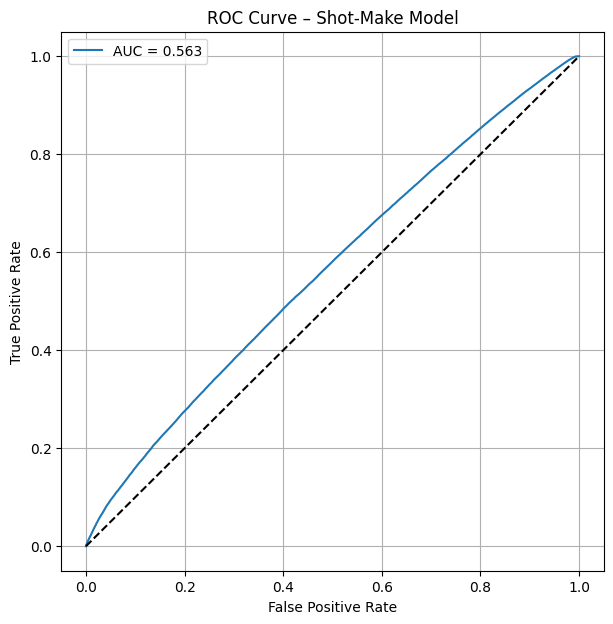

In [38]:
from sklearn.metrics import roc_curve, auc

proba_test = model.predict_proba(X_test)[:,1]

fpr, tpr, thresh = roc_curve(y_test, proba_test)
roc_val = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f"AUC = {roc_val:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


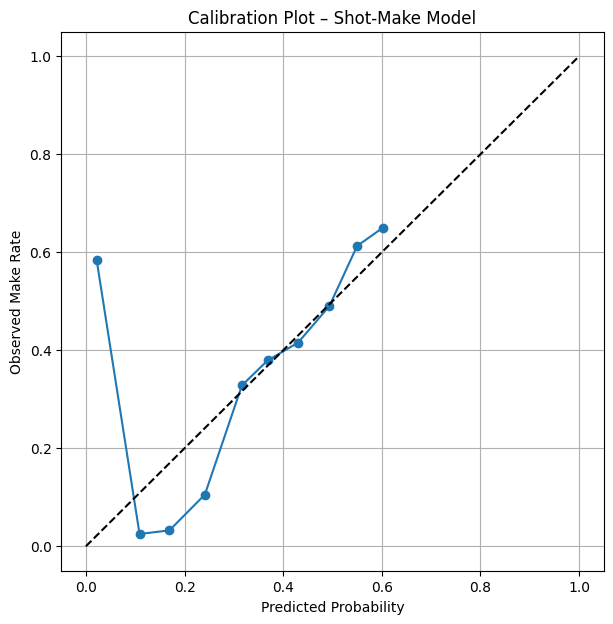

In [39]:
# ============================================================
# CALIBRATION CURVE (FIXED)
# ============================================================

from sklearn.calibration import calibration_curve

# correct probability vector for the test set
proba_test = model.predict_proba(X_test)[:,1]

prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=15)

plt.figure(figsize=(7,7))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Make Rate")
plt.title("Calibration Plot – Shot-Make Model")
plt.grid(True)
plt.show()


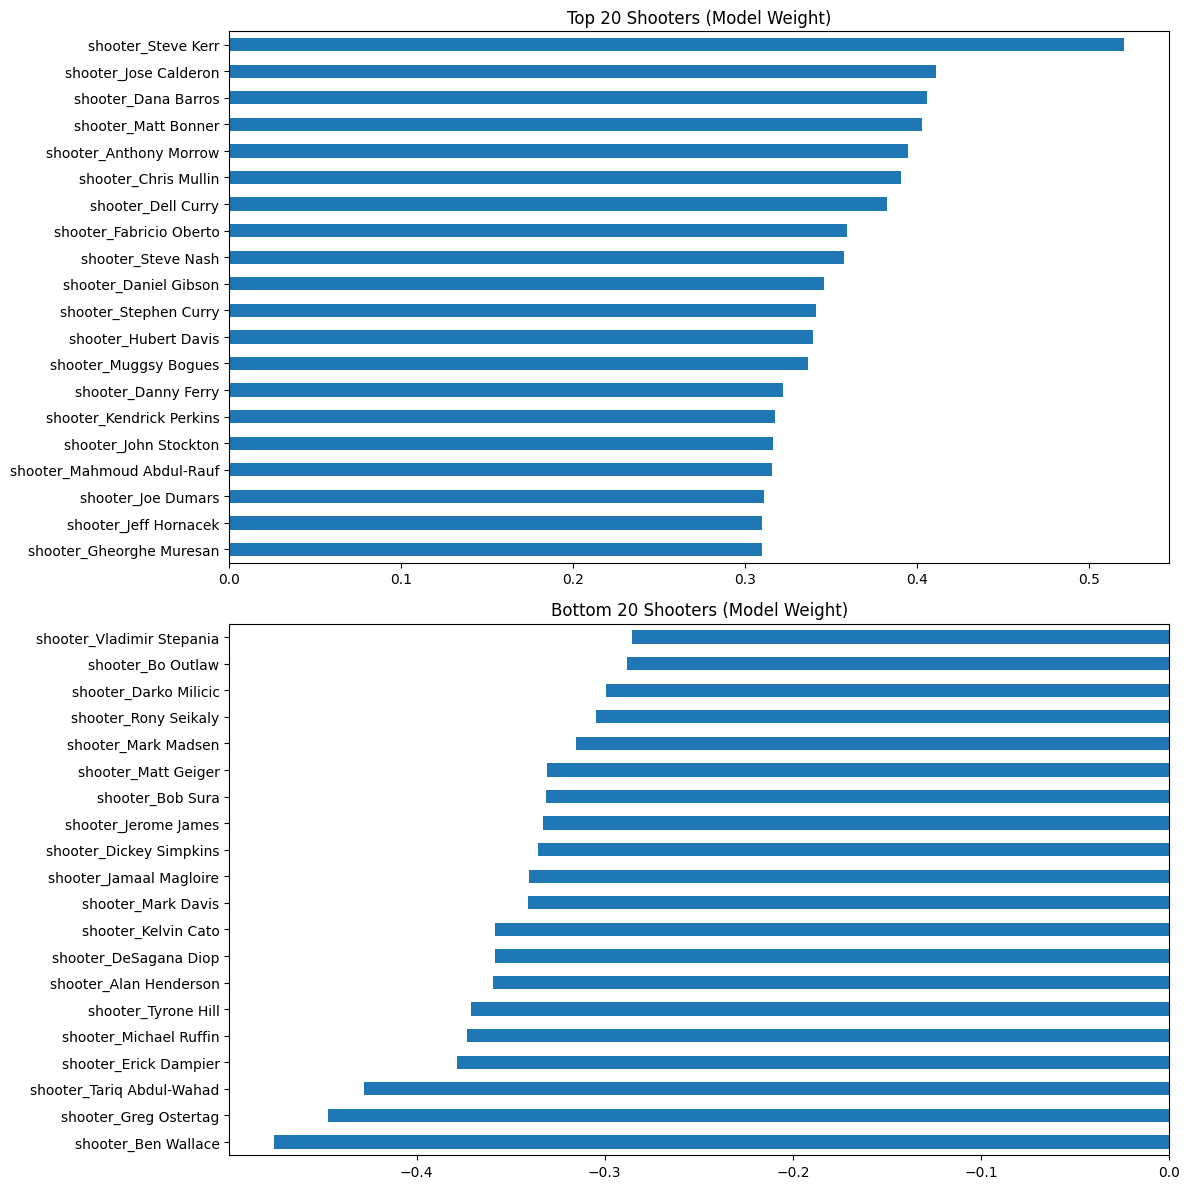

In [37]:
# ============================================================
# SHOOTER COEFFICIENTS (Top 20 and Bottom 20)
# ============================================================

# extract shooter coefficients from LR model
coefs = model.coef_[0][1:]   # first coef is for shot_distance
shooter_coefs = pd.Series(coefs, index=enc.get_feature_names_out(["shooter"]))

shooter_coefs_sorted = shooter_coefs.sort_values()

plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
shooter_coefs_sorted.tail(20).plot(kind="barh")
plt.title("Top 20 Shooters (Model Weight)")

plt.subplot(2,1,2)
shooter_coefs_sorted.head(20).plot(kind="barh")
plt.title("Bottom 20 Shooters (Model Weight)")

plt.tight_layout()
plt.show()


In [40]:
# ============================================================
# POSSESSION SIMULATOR (MARKOV CHAIN)
# ============================================================

import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import random

# extract event sequence per possession
events = df[["possession_id", "event_class"]]
events = events[events["event_class"].notna()]

poss_to_events = (
    events.groupby("possession_id")["event_class"]
    .apply(list)
    .to_dict()
)

# build transition counts
transition_counts = defaultdict(Counter)

for seq in poss_to_events.values():
    for a, b in zip(seq[:-1], seq[1:]):
        transition_counts[a][b] += 1

# convert to probabilities
transition_probs = {}

for a, counter in transition_counts.items():
    total = sum(counter.values())
    transition_probs[a] = {
        b: counter[b] / total for b in counter
    }

# function to simulate a possession
def simulate_possession(max_steps=20):
    # start state (empirically common start states)
    state = "jump_ball"
    sequence = [state]

    for _ in range(max_steps):
        if state not in transition_probs:
            break
        next_states = list(transition_probs[state].keys())
        probs = list(transition_probs[state].values())
        state = random.choices(next_states, probs)[0]
        sequence.append(state)
        if state in ["shot_make", "turnover", "rebound"]:
            break

    return sequence

# generate sample possessions
for i in range(5):
    print(simulate_possession())


['jump_ball', 'shot_make']
['jump_ball', 'rebound']
['jump_ball', 'shot_make']
['jump_ball', 'shot_miss', 'rebound']
['jump_ball', 'shot_miss', 'rebound']


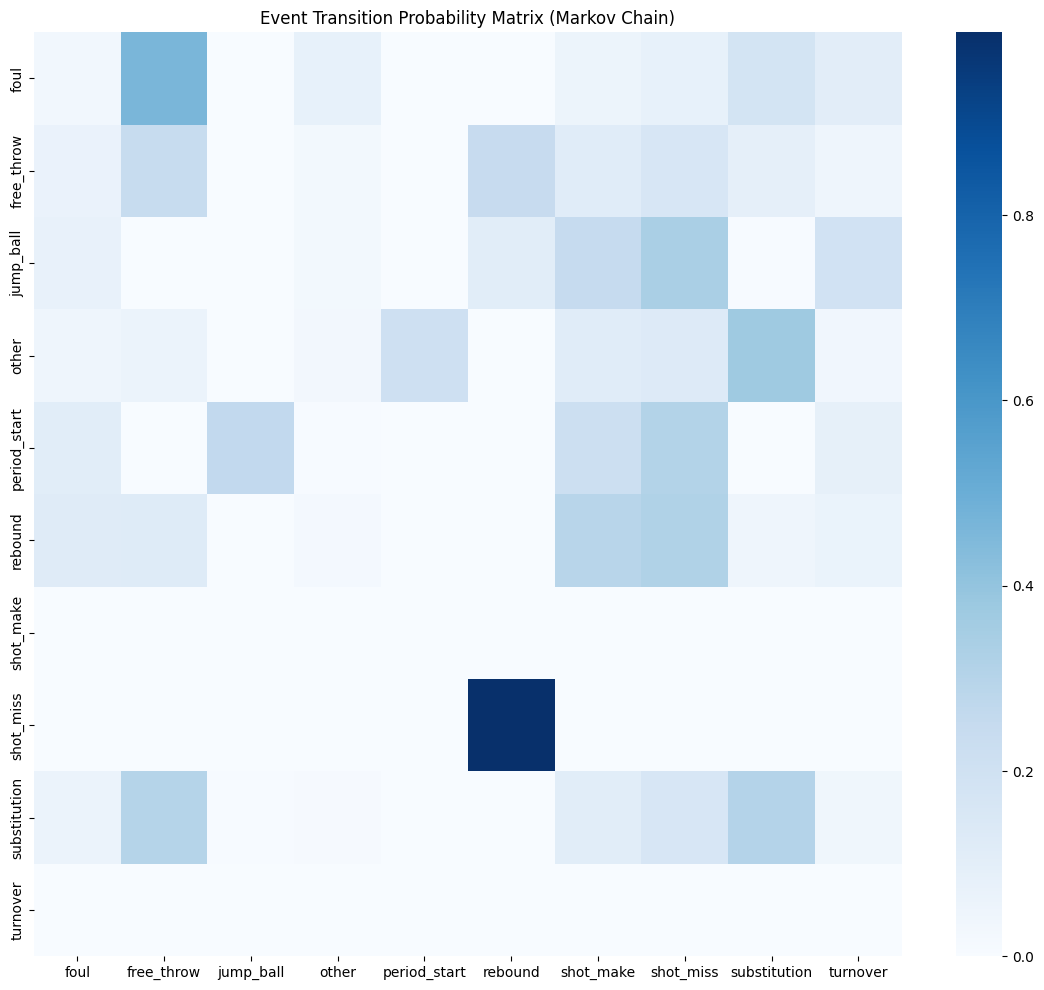

In [43]:
# ============================================================
# EVENT TRANSITION PROBABILITY MATRIX (FIXED)
# ============================================================

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# collect all events that appear as source
source_events = set(transition_counts.keys())

# collect all events that appear as target
target_events = set()
for src, nxts in transition_counts.items():
    for tgt in nxts.keys():
        target_events.add(tgt)

# union of both
all_events = sorted(list(source_events.union(target_events)))

# mapping event -> matrix index
event_index = {e: i for i, e in enumerate(all_events)}

# build probability matrix
matrix = np.zeros((len(all_events), len(all_events)))

for a, nexts in transition_probs.items():
    for b, p in nexts.items():
        matrix[event_index[a], event_index[b]] = p

plt.figure(figsize=(14,12))
sns.heatmap(matrix, xticklabels=all_events, yticklabels=all_events, cmap="Blues")
plt.title("Event Transition Probability Matrix (Markov Chain)")
plt.show()


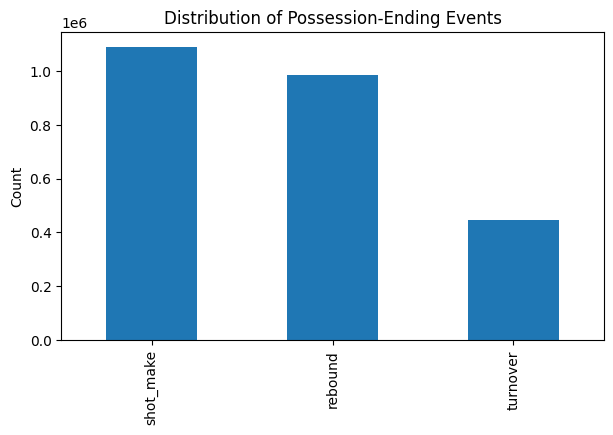

In [44]:
terminal_events = []

for seq in poss_to_events.values():
    for ev in reversed(seq):
        if ev in ["shot_make", "shot_miss", "turnover", "rebound"]:
            terminal_events.append(ev)
            break

pd.Series(terminal_events).value_counts().plot(kind="bar", figsize=(7,4))
plt.title("Distribution of Possession-Ending Events")
plt.ylabel("Count")
plt.show()


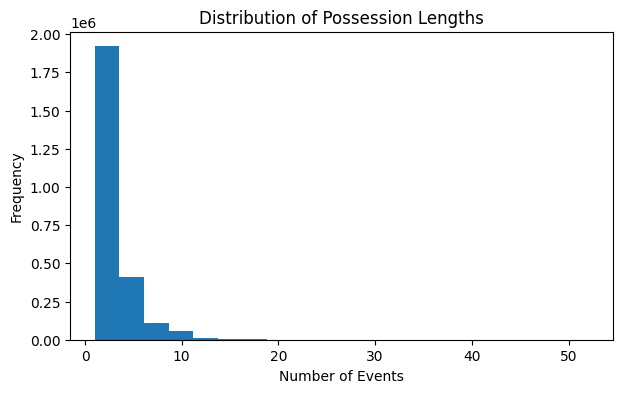

In [45]:
lengths = [len(seq) for seq in poss_to_events.values()]
pd.Series(lengths).plot(kind="hist", bins=20, figsize=(7,4))
plt.title("Distribution of Possession Lengths")
plt.xlabel("Number of Events")
plt.ylabel("Frequency")
plt.show()


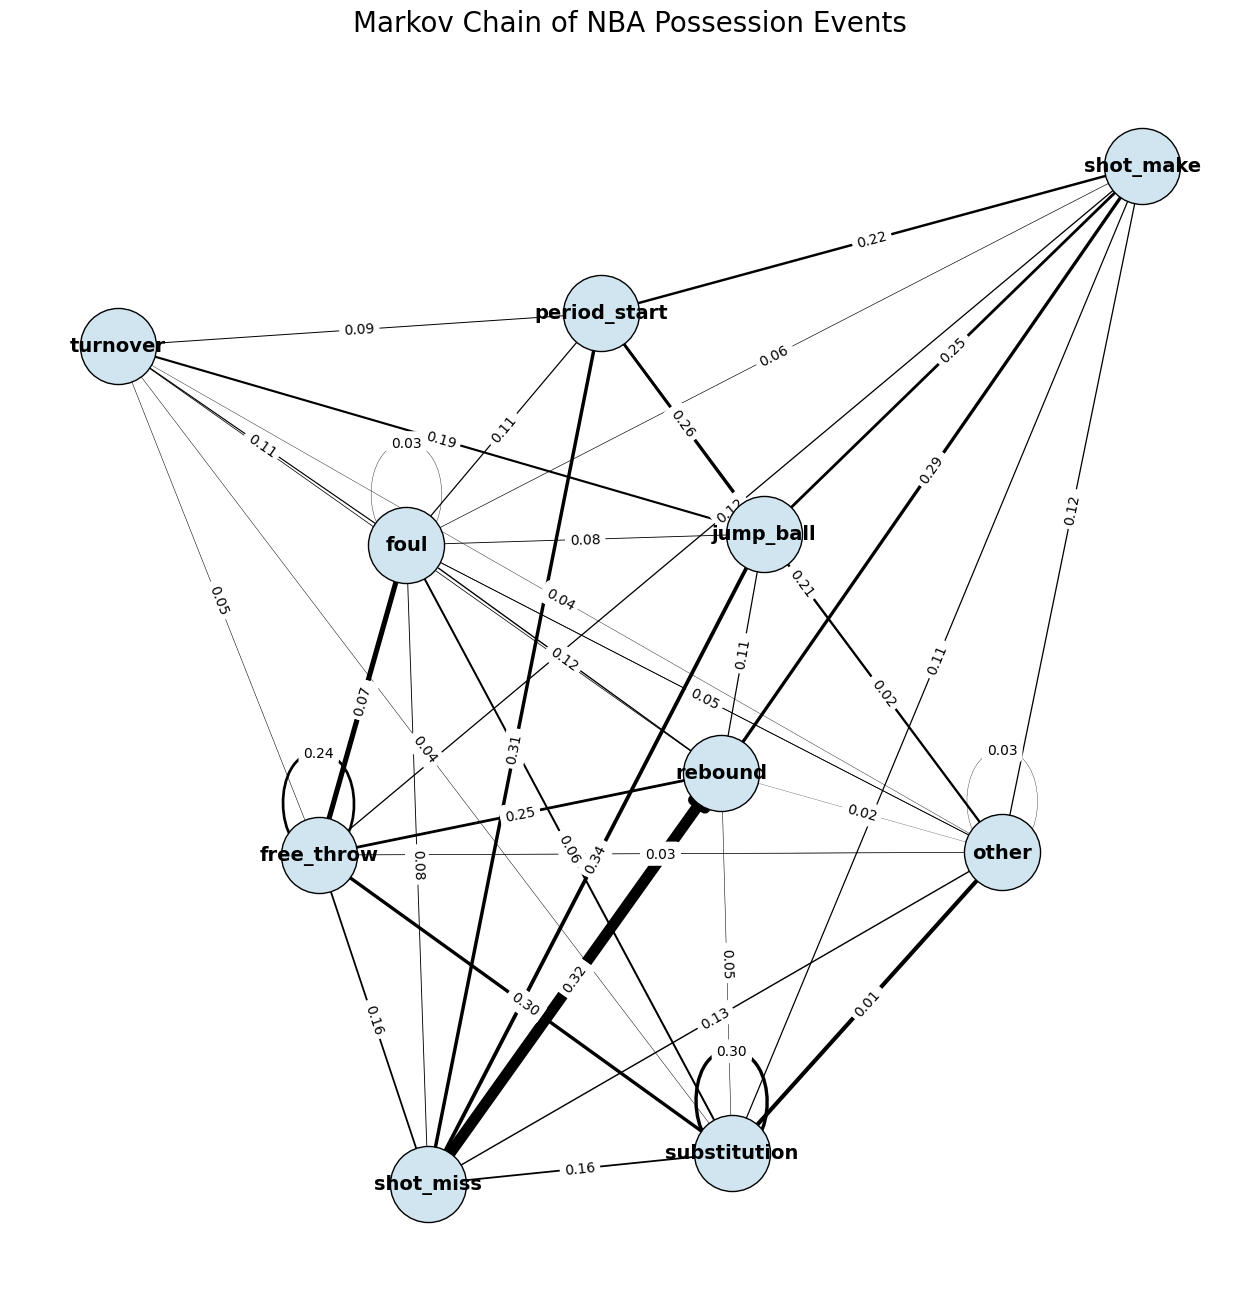

In [50]:
# ============================================================
# MARKOV CHAIN DIAGRAM (POSSESSION STATE GRAPH)
# ============================================================

import networkx as nx
import matplotlib.pyplot as plt

# build directed graph
MC = nx.DiGraph()

# add edges with weights (probabilities)
for a, nexts in transition_probs.items():
    for b, p in nexts.items():
        # ignore extremely rare transitions to keep diagram clear
        if p < 0.01:
            continue
        MC.add_edge(a, b, weight=p)

plt.figure(figsize=(16, 16))

# spring layout spacing
pos = nx.spring_layout(MC, k=1.0, seed=42)

# extract edge weights
weights = [MC[u][v]["weight"] * 8 for u, v in MC.edges()]  # scale for visibility

# draw nodes
nx.draw_networkx_nodes(MC, pos,
                       node_size=3000,
                       node_color="#d1e5f0",
                       edgecolors="black")

# draw labels
nx.draw_networkx_labels(MC, pos, font_size=14, font_weight="bold")

# draw edges
nx.draw_networkx_edges(MC, pos,
                       width=weights,
                       arrowsize=25,
                       arrowstyle="-|>")

# OPTIONAL: show transition probabilities on edges
edge_labels = {(u, v): f"{MC[u][v]['weight']:.2f}" for u, v in MC.edges()}
nx.draw_networkx_edge_labels(MC, pos,
                             edge_labels=edge_labels,
                             font_size=10)

plt.title("Markov Chain of NBA Possession Events", fontsize=20, pad=20)
plt.axis("off")

plt.savefig("markov_chain_possession_diagram.png", dpi=300, bbox_inches="tight")
plt.show()
